# Evaluation

In [200]:
# Importing libraries
import torchio as tio
import glob
import numpy as np
import random
import os
import pickle

from collections import OrderedDict
from pathlib import Path

from tqdm import tqdm
import time

import torchio as tio
from torchio.transforms import (RescaleIntensity,RandomFlip,Compose, HistogramStandardization)

from sklearn.metrics import accuracy_score,f1_score

from torch.utils.data import DataLoader
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from scipy.ndimage import zoom

In [2]:
from lime import lime_image

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [3]:
import shap

## DataLoaders

In [4]:
with open('../3_Classifier_training/study_test_design', 'rb') as f:
    study_design = pickle.load(f)

In [5]:
# Torchio's subjects' dictionary
subjects_list={}

for group in study_design.keys():
    subjects_list[group]={}
    for dataset in study_design[group].keys():
        subjects_list[group][dataset]={}
        for types in study_design[group][dataset].keys():
            subjects_list[group][dataset][types]=[tio.Subject(chiasm=tio.Image(study_design[group][dataset][types][sub]['chiasm'], type=tio.INTENSITY), label=study_design[group][dataset][types][sub]['class']) for sub in study_design[group][dataset][types].keys()]
            # remove if doesn't exist
            if not subjects_list[group][dataset][types]:
                del subjects_list[group][dataset][types]

In [6]:
# Histogram standardization (to mitigate cross-site differences)

chiasm_paths=[]

# Obtain paths of all chiasm images
for group in study_design.keys():
    #print(group)
    for dataset in study_design[group]:
        #print(dataset)
        for types in study_design[group][dataset]:
            if types != 'other':
                for subjects in study_design[group][dataset][types]:
                    chiasm_paths.append(study_design[group][dataset][types][subjects]['chiasm'])

#chiasm_landmarks_path = Path('chiasm_landmarks.npy')    

chiasm_landmarks = HistogramStandardization.train(chiasm_paths)
#torch.save(chiasm_landmarks, chiasm_landmarks_path)

landmarks={'chiasm': chiasm_landmarks}

standardize = HistogramStandardization(landmarks)
                    
'''
# For t1
t1_paths = [design['train'][sub]['brain'] for sub in design['train']]
t1_landmarks_path = Path('t1_landmarks.npy')

t1_landmarks = HistogramStandardization.train(t1_paths)
torch.save(t1_landmarks, t1_landmarks_path)

# For probs
probs_paths = [design['train'][sub]['probs'] for sub in design['train']]
probs_landmarks_path = Path('probs_landmarks.npy')

probs_landmarks = HistogramStandardization.train(probs_paths)
torch.save(probs_landmarks, probs_landmarks_path)

landmarks={'t1':t1_landmarks,#'t1_landmarks.npy',
            'probs': probs_landmarks}# 'probs_landmarks.npy'}

torch.save(landmarks, 'path_to_landmarks.pth')

standardize = HistogramStandardization('path_to_landmarks.pth')
'''

100%|██████████| 1665/1665 [00:06<00:00, 260.88it/s]


"\n# For t1\nt1_paths = [design['train'][sub]['brain'] for sub in design['train']]\nt1_landmarks_path = Path('t1_landmarks.npy')\n\nt1_landmarks = HistogramStandardization.train(t1_paths)\ntorch.save(t1_landmarks, t1_landmarks_path)\n\n# For probs\nprobs_paths = [design['train'][sub]['probs'] for sub in design['train']]\nprobs_landmarks_path = Path('probs_landmarks.npy')\n\nprobs_landmarks = HistogramStandardization.train(probs_paths)\ntorch.save(probs_landmarks, probs_landmarks_path)\n\nlandmarks={'t1':t1_landmarks,#'t1_landmarks.npy',\n            'probs': probs_landmarks}# 'probs_landmarks.npy'}\n\ntorch.save(landmarks, 'path_to_landmarks.pth')\n\nstandardize = HistogramStandardization('path_to_landmarks.pth')\n"

In [290]:
# Data preprocessing and augmentation

# Rescale
rescale = RescaleIntensity((0,1))

# Flip
flip = RandomFlip((0,1,2), flip_probability=0.5, p=0.25)

# Affine transformations
affine = tio.RandomAffine(degrees=15)

# Elastic deformation
elastic = tio.transforms.RandomElasticDeformation(num_control_points=5, max_displacement=2, locked_borders=2)

# Bias field (???)

# Composing transforms - flip serves as data augmentation and is used only for training
transform_train = Compose([standardize, rescale]) # no affine
transform_other = Compose([standardize, elastic, rescale]) # no affine
transform_dev = Compose([standardize, rescale])

In [291]:
# Define datasets

# Torchio's subjects' dictionary
datasets_list={}

for group in subjects_list.keys():
    
    datasets_list[group]={}
    
    for dataset in subjects_list[group].keys():
        
        datasets_list[group][dataset]={}
        
        for types in subjects_list[group][dataset].keys():
            
            # Selection of the right transformation
            if types == 'other':
                applied_transformation = transform_other
            elif (group == 'train'):
                applied_transformation = transform_train
            else:
                applied_transformation = transform_dev
            
            print(group, dataset,types, applied_transformation)
            datasets_list[group][dataset][types]=tio.SubjectsDataset(subjects_list[group][dataset][types], transform = applied_transformation) 

train UoN control Compose([HistogramStandardization(landmarks={'chiasm': array([  0.        ,   8.27041873,  14.21580763,  17.77596941,
        21.78219392,  30.37783223,  37.99933659,  43.9362286 ,
        49.1441514 ,  51.96888265,  55.39377391,  66.63455637,
       100.        ])}, masking_method=None), RescaleIntensity(out_min_max=(0, 1), percentiles=(0, 100), masking_method=None)])
train UoN other Compose([HistogramStandardization(landmarks={'chiasm': array([  0.        ,   8.27041873,  14.21580763,  17.77596941,
        21.78219392,  30.37783223,  37.99933659,  43.9362286 ,
        49.1441514 ,  51.96888265,  55.39377391,  66.63455637,
       100.        ])}, masking_method=None), RandomElasticDeformation(), RescaleIntensity(out_min_max=(0, 1), percentiles=(0, 100), masking_method=None)])
train UoN albinism Compose([HistogramStandardization(landmarks={'chiasm': array([  0.        ,   8.27041873,  14.21580763,  17.77596941,
        21.78219392,  30.37783223,  37.99933659,  43.9362

In [292]:
# Concatenate required datasets
concatenated_datasets={}

for group in datasets_list:

    entry=[]
    
    for dataset in datasets_list[group].keys():
    
    
        for types in datasets_list[group][dataset].keys():
            
            #print(group, dataset, types)
            
            entry.append(datasets_list[group][dataset][types])
    
    concatenated_datasets[group]=torch.utils.data.ConcatDataset(entry)

In [293]:
# Create dataloaders
dataloaders_chiasm={'train': DataLoader(dataset=concatenated_datasets['train'], batch_size=10, shuffle=True, num_workers=8),
                   'dev_train': DataLoader(dataset=concatenated_datasets['dev_train'], batch_size=10, shuffle=True, num_workers=8),
                   'dev_test': DataLoader(dataset=concatenated_datasets['dev_test'], batch_size=10, shuffle=True, num_workers=8),
                   'test_1': DataLoader(dataset=concatenated_datasets['test_1'], batch_size=10, shuffle=True, num_workers=8),
                   'test_2': DataLoader(dataset=concatenated_datasets['test_2'], batch_size=10, shuffle=True, num_workers=8),
                   }


train


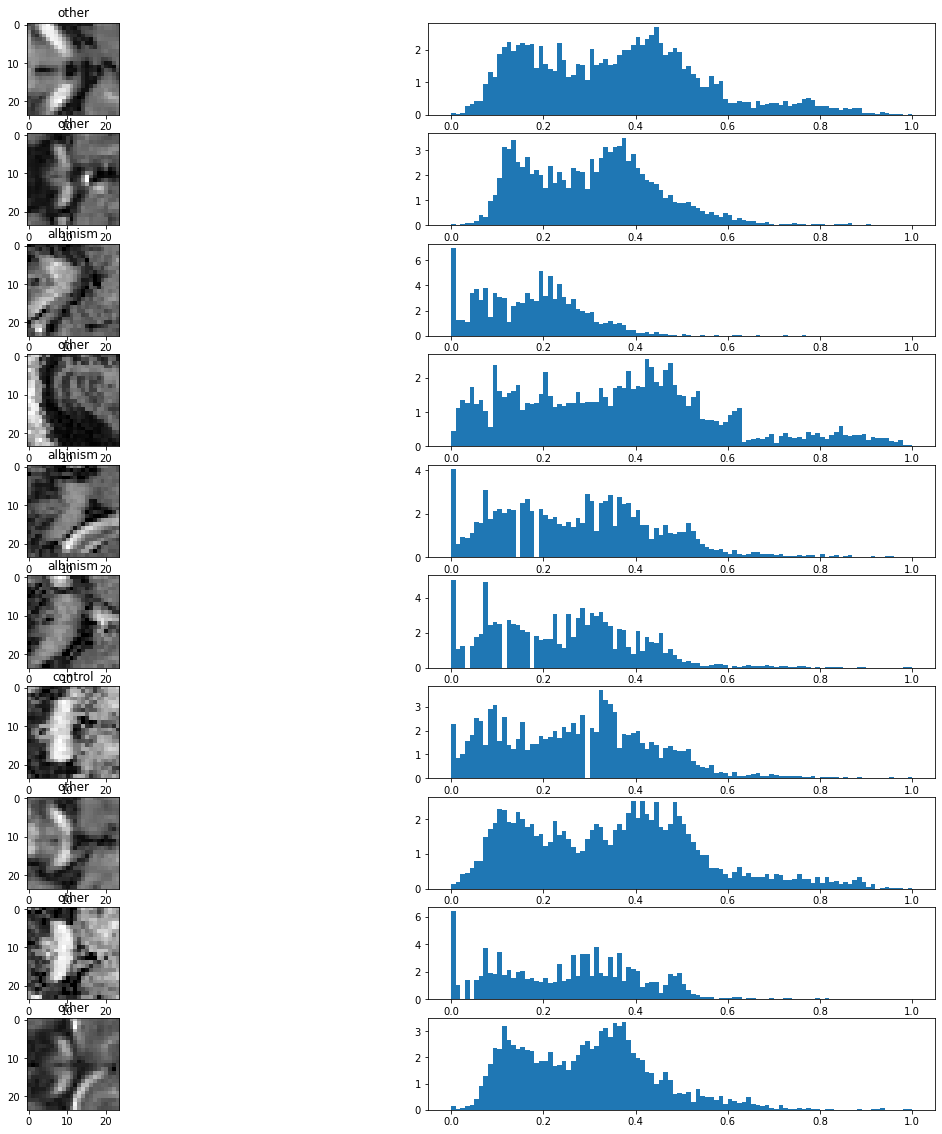

dev_train


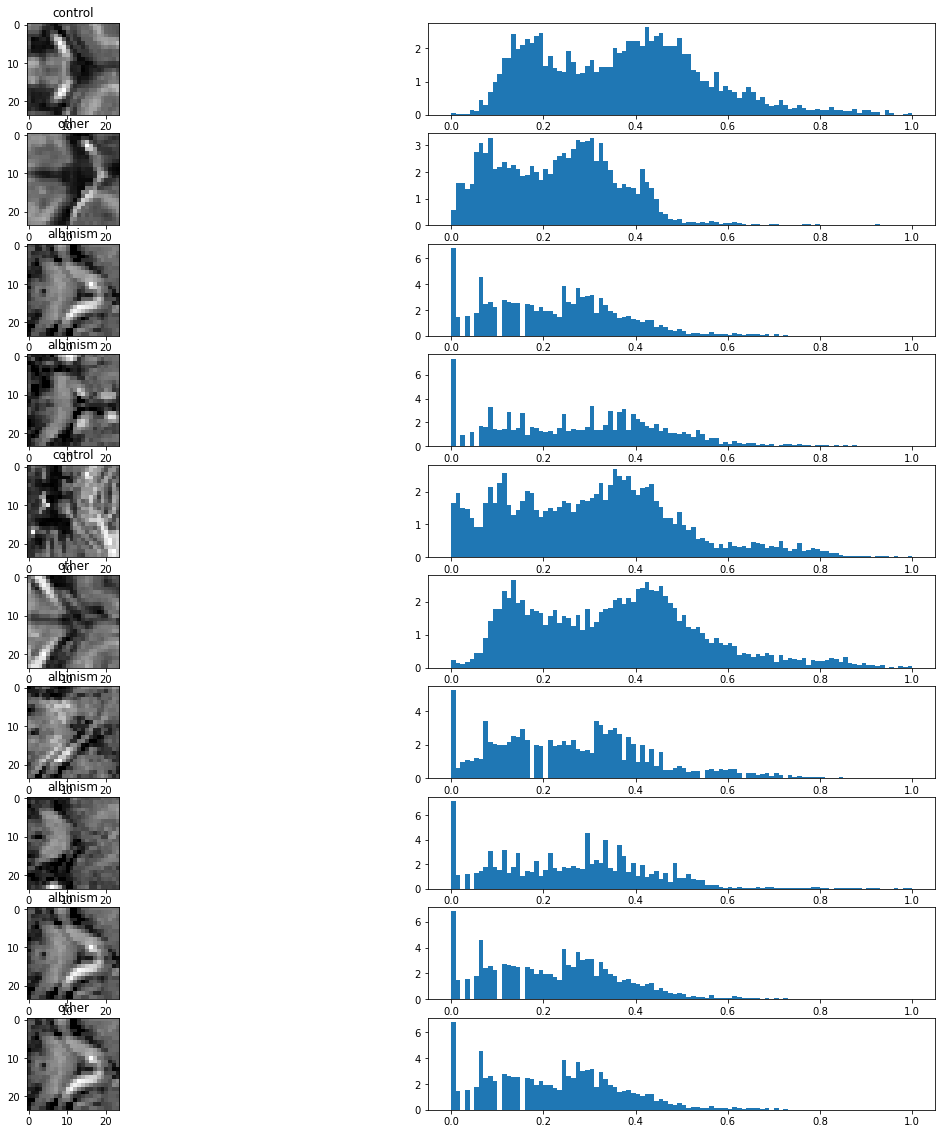

dev_test


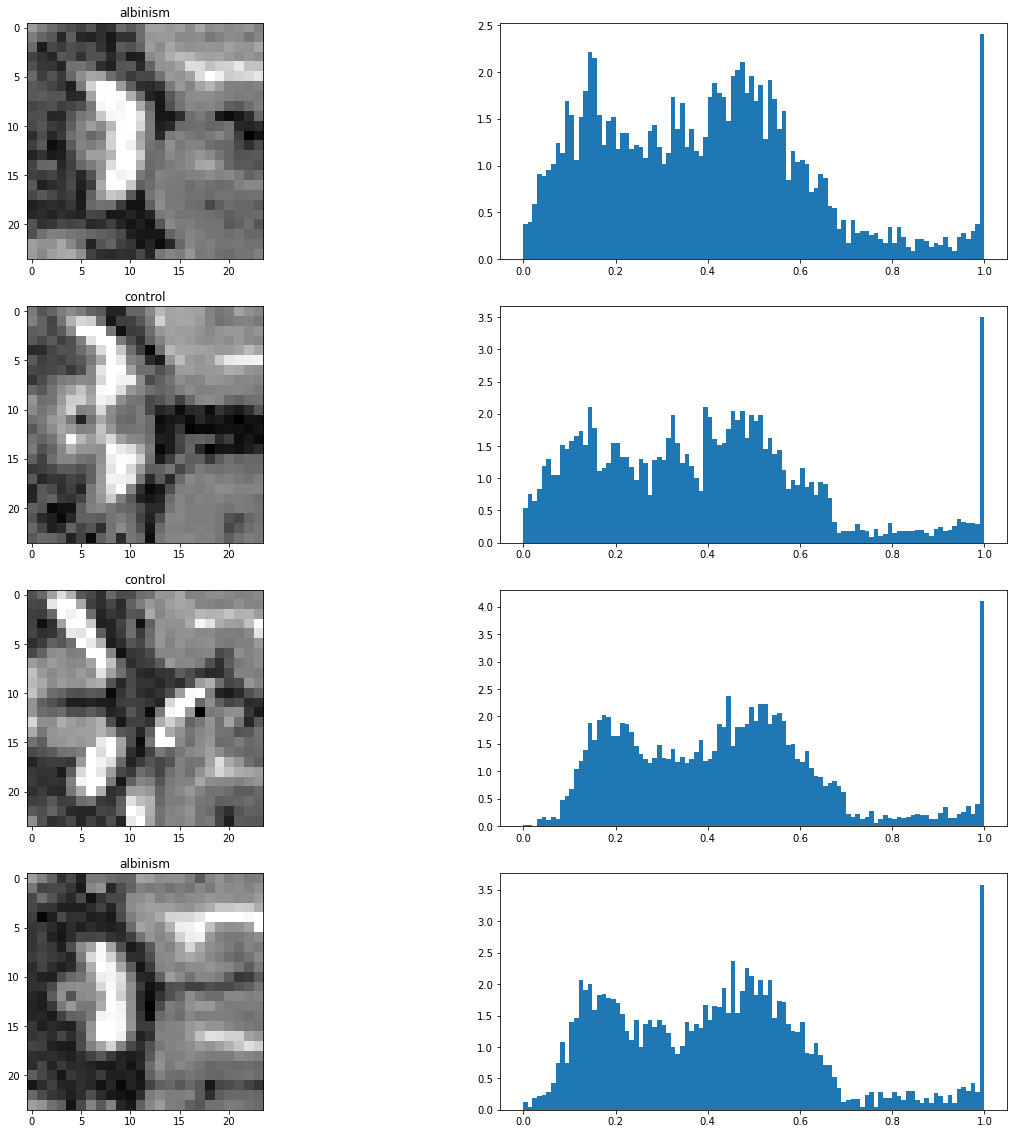

In [294]:
# Visualize results
classes=['control','albinism','other']

for group in ['train', 'dev_train', 'dev_test']:
    
    print(group)
    
    batch = next(enumerate(dataloaders_chiasm[group]))
    
    data = batch[1]['chiasm']['data']
    labels = batch[1]['label']
    
    inputs = data.cpu().numpy()

        
    fig = plt.figure(figsize=(20,20))
    
    for i in range(inputs.shape[0]):
        
        plt.subplot(inputs.shape[0],2,2*i+1)
        plt.imshow(inputs[i,0,:,:,5],cmap='gray');
        plt.title(classes[labels[i]])    
        plt.subplot(inputs.shape[0],2,2*i+2)
        plt.hist(inputs[i,0].reshape(-1),density=True, bins=100);
        plt.axis('on')
    
    plt.show()

# Models

In [295]:
# Cropped U-Net copied from Overfitting Model

class UNet(nn.Module):
    
    def __init__(self, in_channels=1, out_channels=1, init_features=10, scaling=2):
        super(UNet, self).__init__()
                
        # Encoding layers
        self.encoder1 = self.unet_block(in_channels, init_features, "enc1")
        self.pool1 = nn.AvgPool3d(kernel_size=2, stride=2, padding=0)
        self.encoder2 = self.unet_block(init_features, init_features*scaling, name='enc2')
        self.pool2 = nn.AvgPool3d(kernel_size=2, stride=2, padding=0)

        # Bottleneck layer
        self.bottleneck = self.unet_block(init_features*scaling, init_features*scaling**2, name='bottleneck')
        
        # Decoding layers (where merge with prevois encoding layers occurs)        
        self.upconv2 = nn.ConvTranspose3d(init_features*scaling**2, init_features*scaling, kernel_size=2, stride=2)
        self.decoder2 = self.unet_block(init_features*scaling, init_features*scaling, name='dec2')
                
        self.upconv1 = nn.ConvTranspose3d(init_features*scaling, init_features, kernel_size=2, stride=2)
        self.decoder1 = self.unet_block(init_features, init_features, name='dec1')
        
        # Final convolution - output equals number of output channels
        self.conv = nn.Conv3d(init_features, out_channels, kernel_size=1) 
        
    def forward(self,x):
        
        # Encoding
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool2(enc2))

        # Upconvolving, concatenating data from respective encoding phase and executing UNet block
        dec2 = self.upconv2(bottleneck)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = self.decoder1(dec1)
        
        out_conv = self.conv(dec1)
        
        return torch.sigmoid(out_conv)
    
    def unet_block(self, in_channels, features, name):
        
        return nn.Sequential(OrderedDict([(name+'conv1',nn.Conv3d(in_channels=in_channels, out_channels=features, kernel_size=3, padding=1, bias=False)),
                             (name+'bnorm1', nn.BatchNorm3d(num_features=features)),
                             (name+'relu1', nn.ReLU(inplace=True)),
                             (name+'conv2', nn.Conv3d(in_channels=features, out_channels=features, kernel_size=3, padding=1, bias=False)),
                             (name+'bnorm2', nn.BatchNorm3d(num_features=features)),
                             (name+'relu2', nn.ReLU(inplace=True))])
                            )

    def output_latent_representations(self,x):
        
        print(x.shape)

        # Encoding
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool2(enc2))
        
        print(bottleneck.shape)
        
        return bottleneck

In [296]:
class Classify_chiasm(nn.Module):
    
    def __init__(self, init_features, scaling, num_fc_layers, num_hidden_nodes, weights_path='../../1_Data/2_Trained_AE/'):
        super(Classify_chiasm, self).__init__()
        
        self.init_features = init_features
        self.scaling = scaling
        self.num_fc_layers = num_fc_layers
        self.num_hidden_nodes = num_hidden_nodes
        
        # Initialize the network_extracting_features and load its weights
        network_extracting_features = UNet(1,1,init_features,scaling)
        network_extracting_features.load_state_dict(torch.load(weights_path+'/'+str(init_features)+'_'+str(scaling)+'/optimal_weights'))
        
        child = network_extracting_features.children()
        
        # Copying the desired components (analysis stream) from network_extracting_features
        self.feature_extraction = nn.Sequential(*list(child)[:5])
        
        # Classification layers
        if self.num_fc_layers==0:
            self.classifier = nn.Linear(self.init_features*(self.scaling**2)*6*6*2,3)
        elif self.num_fc_layers==1:
            self.classifier = nn.Sequential(nn.Linear(self.init_features*(self.scaling**2)*6*6*2,self.num_hidden_nodes),nn.ReLU(),nn.Linear(self.num_hidden_nodes,3))
        
        # Placeholder for gradients
        self.gradients = None
    
    # Freeze all the layers apart from the classifying one
    def freeze_feature_extraction(self):
        
        counter = 0
        for layer in classifying_network.children():
            counter += 1
            if counter < 2:
                #print(layer)
                for param in layer.parameters():
                    param.requires_grad = False
            
    # Hook for the activations' gradients
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self,x):
        
        # To ensure that gradients will be tracked
        #x.requires_grad = True
        
        # Feature extraction
        x = self.feature_extraction(x)
        
        # Register the hook
        if self.train and x.requires_grad:
            h = x.register_hook(self.activations_hook)

        # Flatten the image
        #x = torch.flatten(x, start_dim=1)
        x = x.view((x.shape[0], -1))        

        # Classifying FC layer and activation function
        x = self.classifier(x)
        
        return torch.softmax(x, dim=1)

    # Output latent representations (or activations) of the last CNN layer
    def output_latent_representations(self,x):        
        return self.feature_extraction(x)     
    
    # Output gradient
    def output_activation_gradient(self):
        return self.gradients
    
    def gradcam_backup(self, x):
        
        # Calculate prediction
        pred = self.forward(x)
        
        # Get the gradient from the prediction
        pred.backward()
         
        # Extract the gradients from final layer extracting features
        gradients = self.output_activation_gradient()
        print(gradients.shape)
        
        # Pool the gradients
        pooled_gradients = torch.mean(gradients, dim=[0,2,3,4])
        
        # Extract activations
        activations = self.output_latent_representations(x).detach()
        
        # Weight activations by the gradients
        activations[:, i, :, :, :] *= pooled_gradients[i]
        
        # Average the channels of the activations
        heatmap = torch.mean(activations, dim=1).squeeze()
        
        heatmap = np.maximum(heatmap, 0)
        
        heatmap /= torch.max(heatmap)
        
        return heatmap    
        
    def gradcam(self, x, class_id):

        # Calculate prediction
        pred = self.forward(x)

        # Get the gradient from the prediction
        pred[:,class_id].backward()

        # Extract the gradients from final layer extracting features
        gradients = self.output_activation_gradient()

        # Pool the gradients
        pooled_gradients = torch.mean(gradients, dim=[0,2,3,4])

        # Extract activations
        activations = self.output_latent_representations(x).detach()

        # Weight activations by the gradients
        for i in range(self.init_features * self.scaling**2):
            activations[:, i, :, :, :] *= pooled_gradients[i]

        # Average the channels of the activations
        heatmap = torch.mean(activations, dim=1).squeeze()

        heatmap = np.maximum(heatmap, 0)

        heatmap /= torch.max(heatmap)

        return heatmap    

# Performance evaluation

In [297]:
def evaluate_accuracy(folder_with_networks, dataloader, dataset, group_to_be_evaluated):
    
    criterion = nn.NLLLoss(reduction='sum')
    
    names=[]
    loss=[]
    accuracy=[]
    f1=[]
    
    networks = [os.path.basename(x[0]) for x in os.walk(folder_with_networks)]
    networks=networks[1:]
     
    for network in networks:

        # Create network and load the weights
        params=network.split('_')

        model = Classify_chiasm(int(params[0]),int(params[1]),int(params[2]),int(params[3]))
        model.load_state_dict(torch.load(folder_with_networks+network+'/optimal_weights'))

        # Evaluate the network on desired dataset
        tmp_loss=0.0
        tmp_targets=[]
        tmp_pred=[]
        
        for batch in dataloader[group_to_be_evaluated]:
            
            data=batch['chiasm']['data']
            data.requires_grad = True
                        
            with torch.no_grad():
                
                output = model(data)
                
                tmp_loss +=(criterion(output,batch['label']).item())

                tmp_targets+=batch['label'][:].numpy().tolist()
                tmp_pred+=output.argmax(dim=1).cpu().numpy().tolist()

        names.append(network)
        loss.append(tmp_loss/len(dataset[group_to_be_evaluated]))
        accuracy.append(accuracy_score(tmp_targets,tmp_pred))
        f1.append(f1_score(tmp_targets,tmp_pred, average='weighted'))
        
    # Return the list with results
    return names,loss,accuracy, f1

In [298]:
def plot_training(path_to_saved_output):
    
    with open(path_to_saved_output+'train_loss.pkl', 'rb') as f:
        train_loss=pickle.load(f)

    with open(path_to_saved_output+'dev_train_loss.pkl', 'rb') as f:
        dev_train_loss=pickle.load(f)

    with open(path_to_saved_output+'dev_test_loss.pkl', 'rb') as f:
        dev_test_loss=pickle.load(f)

    with open(path_to_saved_output+'train_acc.pkl', 'rb') as f:
        train_acc=pickle.load(f)

    with open(path_to_saved_output+'dev_train_acc.pkl', 'rb') as f:
        dev_train_acc=pickle.load(f)

    with open(path_to_saved_output+'dev_test_acc.pkl', 'rb') as f:
        dev_test_acc=pickle.load(f)
        
    fig = plt.figure(figsize=(20,5))
    plt.suptitle(os.path.basename(path_to_saved_output))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, label='train')
    plt.plot(dev_train_loss, label='train_dev')
    plt.plot(dev_test_loss, label='test_dev')
    plt.legend();
    plt.title('Loss');
    
    plt.subplot(1,2,2)
    plt.plot(train_acc, label='train')
    plt.plot(dev_train_acc, label='train_dev')
    plt.plot(dev_test_acc, label='test_dev')
    plt.legend();
    plt.title('Accuracy');

In [299]:
def plot_evaluation(names_list, loss_list, acc_list, f1_list, name):
    
    # order lists
    loss_list, names_list, acc_list, f1_list = (list(t) for t in zip(*sorted(zip(loss_list, names_list, acc_list, f1_list))))
    
    # plot with subplots
    fig = plt.figure(figsize=(16,12))
    plt.suptitle(name)
    
    # Cross-entropy loss
    ax1 = plt.subplot(311)
    plt.scatter(names_list, loss_list)
    plt.xticks(rotation=90);
    plt.ylim([-1,0])
    ax1.axes.get_xaxis().set_ticks([])
    plt.title('Losses')
    
    # Accuracy
    ax2 = plt.subplot(312)
    plt.scatter(names_list, acc_list)
    plt.xticks(rotation=90);
    plt.axhline(y=0.5, color='r', linestyle='--')
    plt.ylim([-0.05,1.05])
    ax2.axes.get_xaxis().set_ticks([])
    plt.title('Accuracy')
    
    # F1 score
    ax3 = plt.subplot(313)
    plt.scatter(names_list, f1_list)
    plt.xticks(rotation=90);
    plt.axhline(y=0.5, color='r', linestyle='--')
    plt.ylim([-0.05,1.05])
    plt.title('F1-score')

## Accuracy etc.

In [300]:
plot_names_r1, plot_loss_r1, plot_accuracy_r1, f1_score_r1 = evaluate_accuracy('../../1_Data/3_Trained_classifier_no_rescale_no_freezing//', dataloaders_chiasm, concatenated_datasets, 'dev_test')
plot_names_r2, plot_loss_r2, plot_accuracy_r2, f1_score_r2 = evaluate_accuracy('../../1_Data/3_Trained_classifier/', dataloaders_chiasm, concatenated_datasets, 'dev_test')

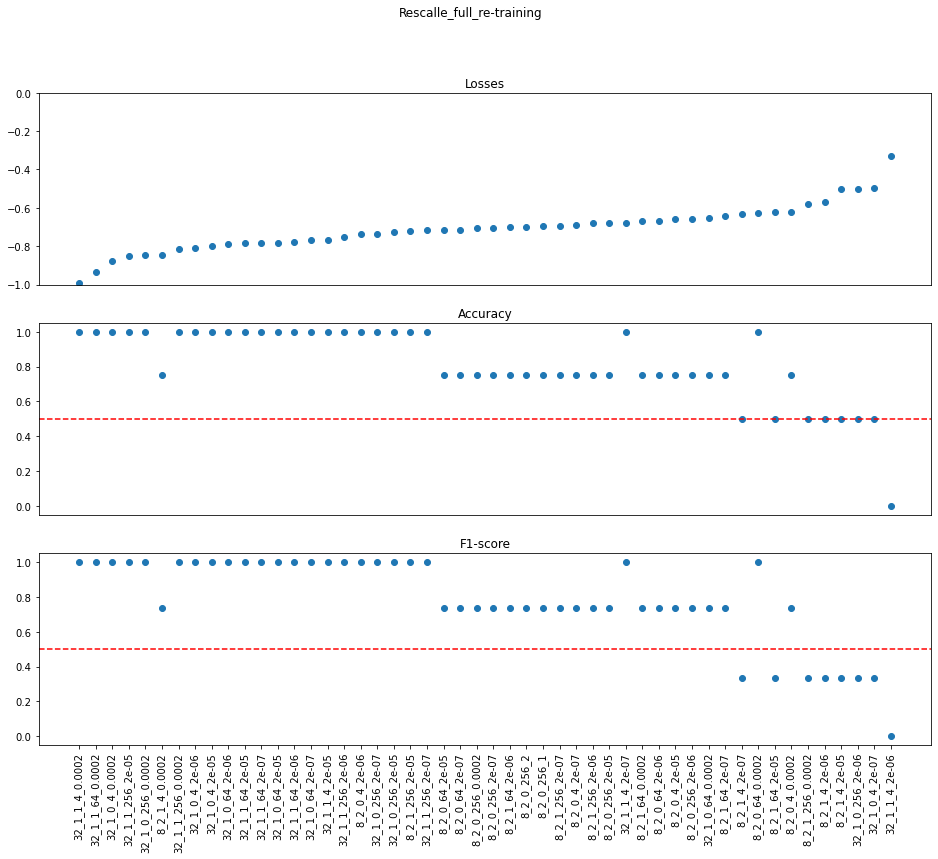

In [301]:
plot_evaluation(plot_names_r1, plot_loss_r1, plot_accuracy_r1, f1_score_r1, 'Rescalle_full_re-training')

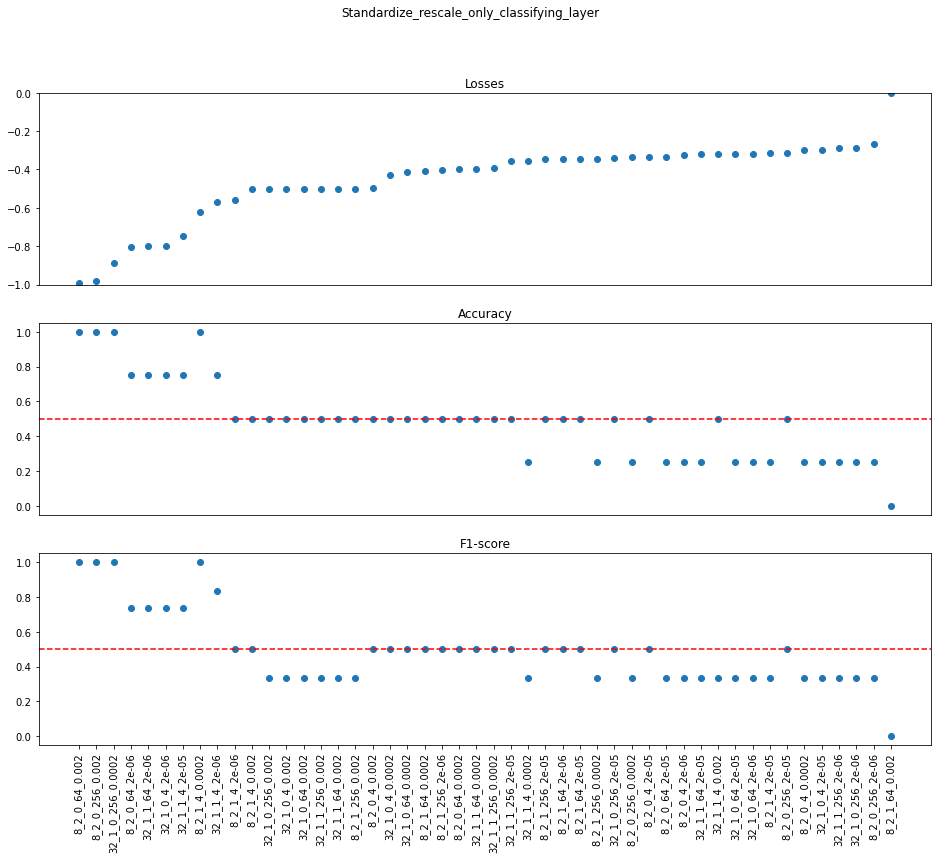

In [302]:
plot_evaluation(plot_names_r2, plot_loss_r2, plot_accuracy_r2, f1_score_r2, 'Standardize_rescale_only_classifying_layer')

## GradCAM

In [303]:
def translate_group(index):
    
    if (index==0):
        return 'control'
    elif (index ==1):
        return 'albinism'
    elif (index==2):
        return 'other'

In [304]:
def plot_gradcam(folder_with_networks, dataloader, group_to_be_evaluated, slice_to_be_shown, architectures=None):
    
    if architectures==None:
        networks = [os.path.basename(x[0]) for x in os.walk(folder_with_networks)]
        networks=networks[1:]
    else:
        networks=architectures
    
    # Fetch data used for evaluation
    batch=next(enumerate(dataloader[group_to_be_evaluated]))[1]
    
    for network in networks:#[0:1]:
        
        print(network)
        
        # Initialize the model
        params=network.split('_')

        model = Classify_chiasm(int(params[0]),int(params[1]),int(params[2]),int(params[3]))
        model.load_state_dict(torch.load(folder_with_networks+network+'/optimal_weights'))
        
        prediction = model(batch['chiasm']['data'])
        
        #print(prediction)
        
        accuracy = accuracy_score(batch['label'],prediction.cpu().argmax(dim=1))
        print('Accuracy = ',accuracy)

        plt.figure(figsize=(10,10))
        
        for i in range(len(batch['label'])):
            
            # original image
            plt.subplot(len(batch['label']),4,4*i+1)
            plt.imshow(batch['chiasm']['data'][i:(i+1)][0,0,:,:,i], cmap='gray', alpha=1)    
            plt.ylabel(translate_group(batch['label'][i]))
            plt.tick_params(axis='both', labelsize=0, length = 0)
            
            # explanation for control
            explanation=model.gradcam(batch['chiasm']['data'][i:(i+1)],0)
            explanation = zoom(explanation,(4,4,4))
            
            plt.subplot(len(batch['label']),4,4*i+2)
            plt.imshow(explanation[:,:,i], cmap='jet', alpha=1)    
            plt.tick_params(axis='both', labelsize=0, length = 0)
            plt.xlabel("{:.2f}".format(prediction[i,0].item()))
            if(i==0):
                plt.title('control')
                
            # explanation for albinism
            explanation=model.gradcam(batch['chiasm']['data'][i:(i+1)],1)
            explanation = zoom(explanation,(4,4,4))
            
            plt.subplot(len(batch['label']),4,4*i+3)
            plt.imshow(explanation[:,:,i], cmap='jet', alpha=1)    
            plt.tick_params(axis='both', labelsize=0, length = 0)
            plt.xlabel("{:.2f}".format(prediction[i,1].item()))
            if(i==0):
                plt.title('albinism')
                
            # explanation for other
            explanation=model.gradcam(batch['chiasm']['data'][i:(i+1)],2)
            explanation = zoom(explanation,(4,4,4))
            
            plt.subplot(len(batch['label']),4,4*i+4)
            plt.imshow(explanation[:,:,i], cmap='jet', alpha=1)    
            plt.tick_params(axis='both', labelsize=0, length = 0)
            plt.xlabel("{:.2f}".format(prediction[i,2].item()))
            if(i==0):
                plt.title('other')
                
        plt.show()

In [305]:
#plot_gradcam('../../1_Data/3_Trained_classifier_no_rescale_no_freezing/',dataloaders_chiasm,'dev_test',4)

32_1_0_256_0.0002
Accuracy =  1.0


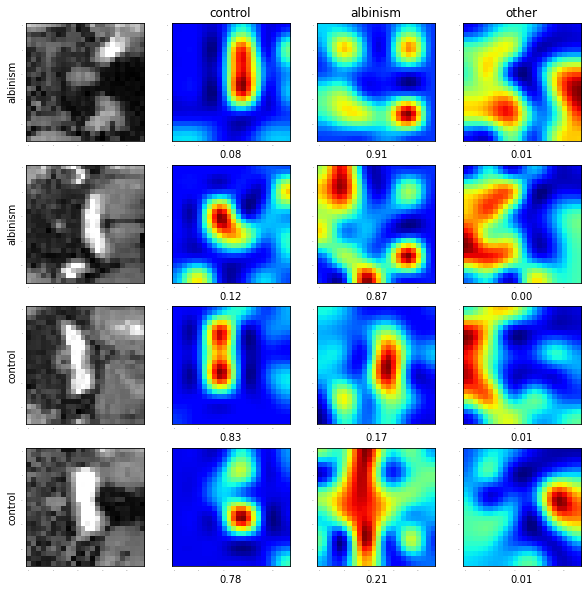

32_1_1_64_2e-07
Accuracy =  1.0


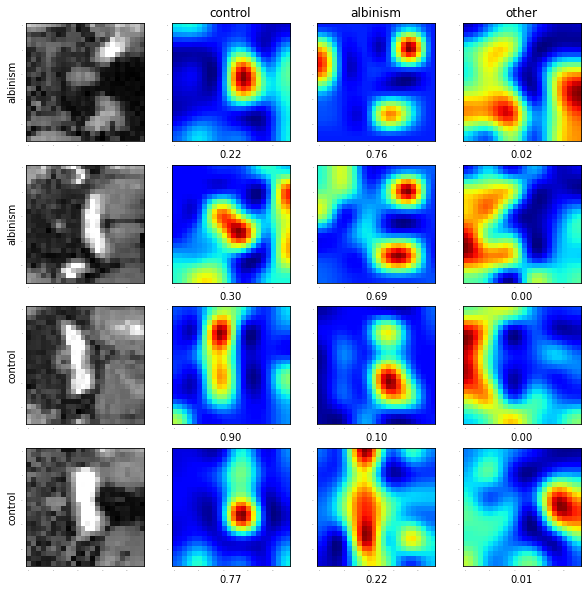

32_1_0_4_2e-06
Accuracy =  1.0


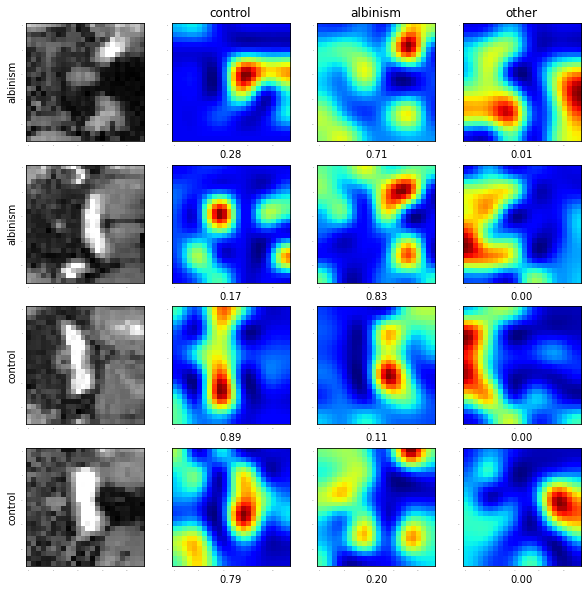

In [306]:
# Most promising candidates
plot_gradcam('../../1_Data/3_Trained_classifier_no_rescale_no_freezing//',dataloaders_chiasm,'dev_test',4,['32_1_0_256_0.0002', '32_1_1_64_2e-07','32_1_0_4_2e-06'])

In [ ]:
#plot_gradcam('../../1_Data/3_Trained_classifier/',dataloaders_chiasm,'dev_test',4)

8_2_1_256_2e-06
Accuracy =  0.5


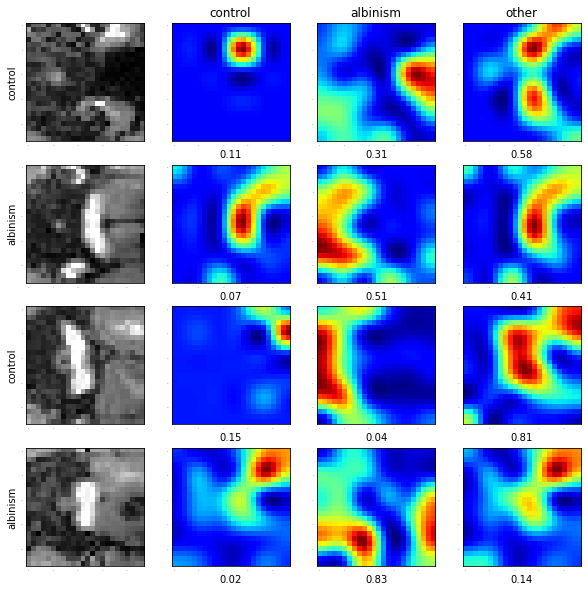

8_2_0_256_0.002
Accuracy =  1.0


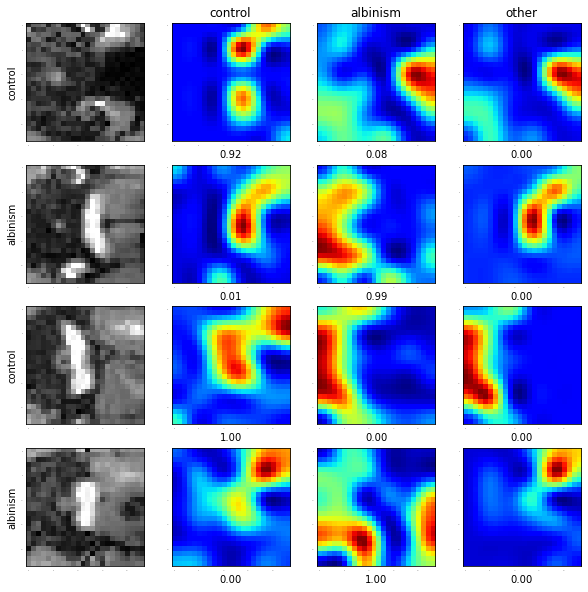

8_2_0_64_0.002
Accuracy =  1.0


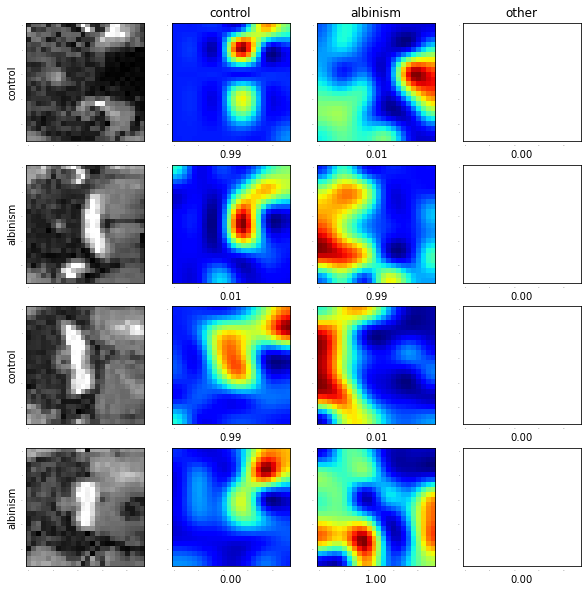

8_2_1_4_0.002
Accuracy =  0.5


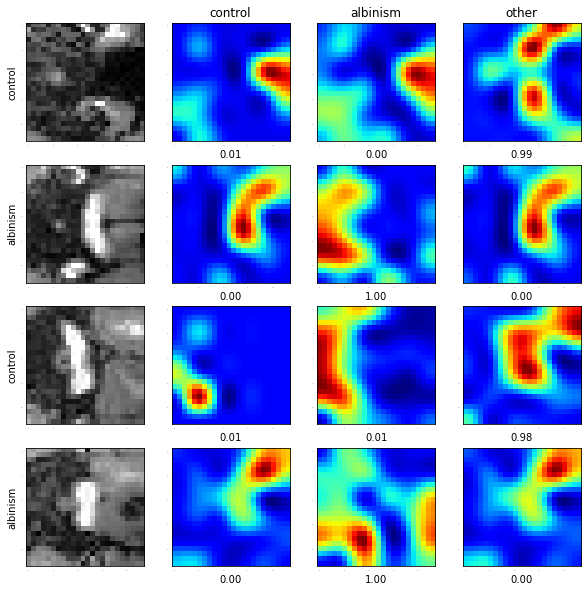

32_1_0_256_0.0002
Accuracy =  1.0


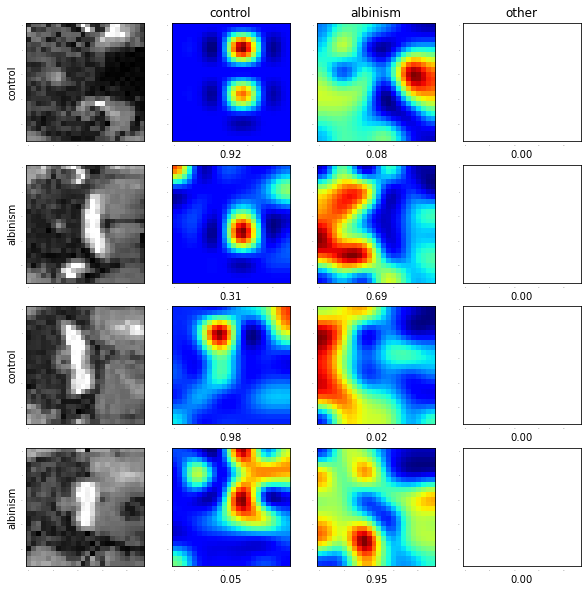

In [307]:
# Most promising candidates
plot_gradcam('../../1_Data/3_Trained_classifier/',dataloaders_chiasm,'dev_test',4,['8_2_1_256_2e-06','8_2_0_256_0.002','8_2_0_64_0.002','8_2_1_4_0.002','32_1_0_256_0.0002'])

## Training plots

32_1_0_256_0.0002


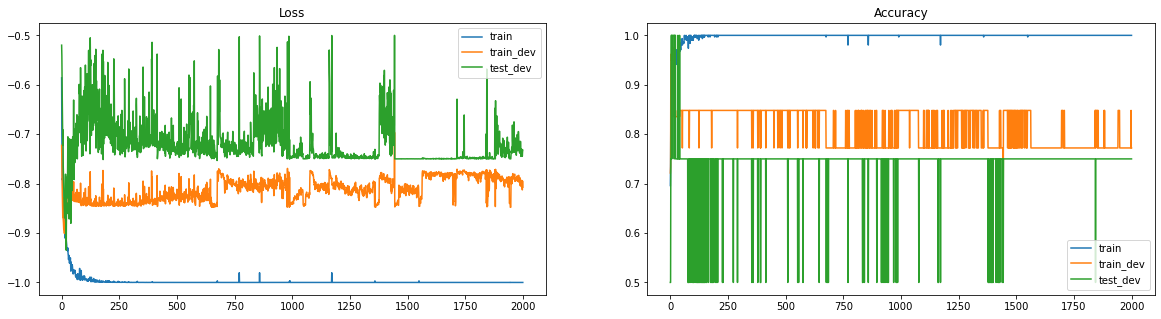

32_1_1_64_2e-07


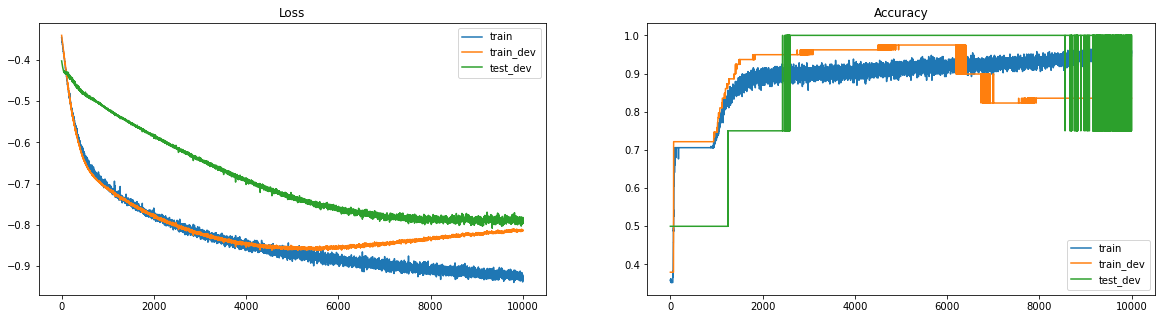

32_1_0_4_2e-06


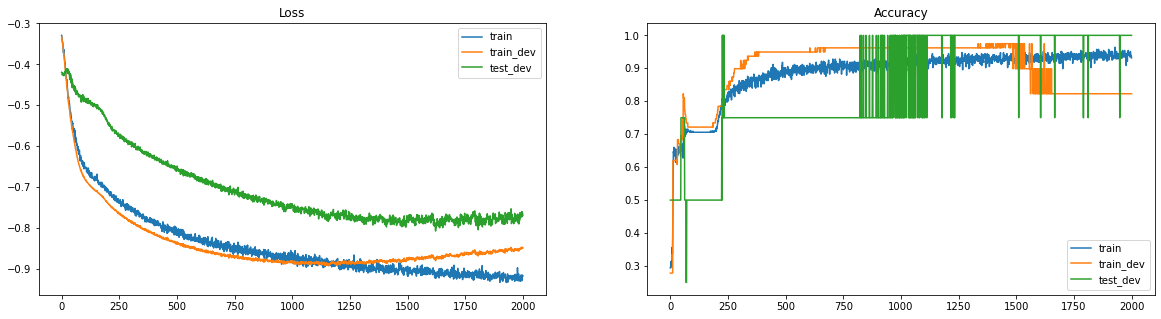

In [282]:
for i in ['32_1_0_256_0.0002', '32_1_1_64_2e-07','32_1_0_4_2e-06']:
    print(i)
    plot_training('../../1_Data/3_Trained_classifier_no_rescale_no_freezing//'+i+'/')
    plt.show()

8_2_1_256_2e-06


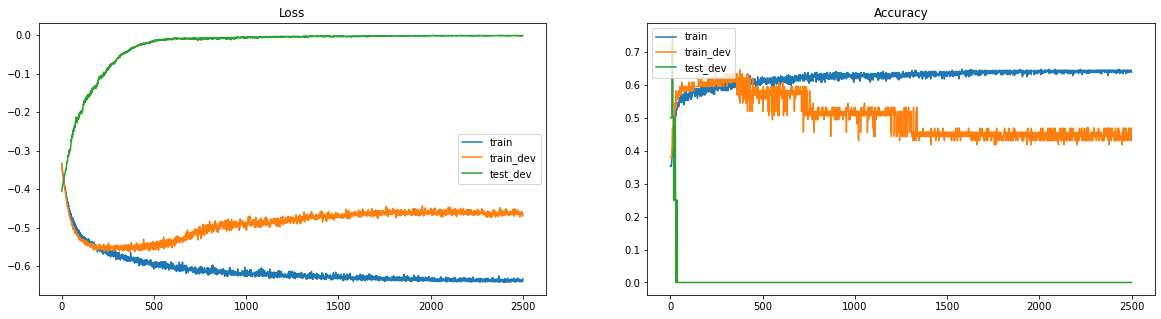

8_2_0_256_0.002


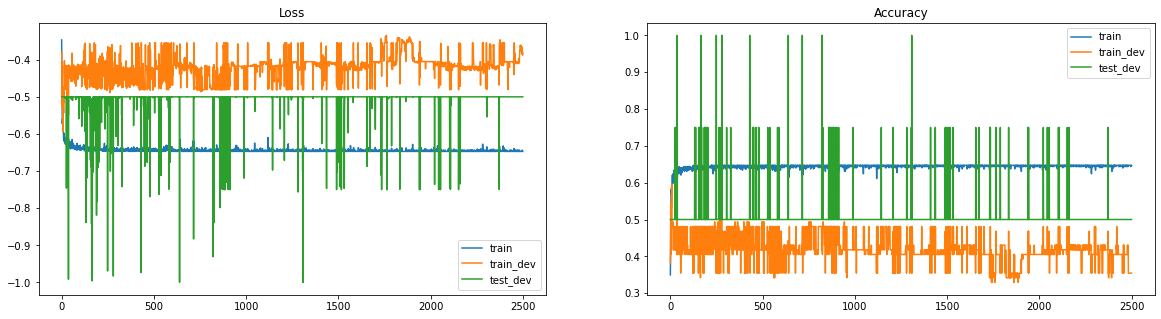

8_2_0_64_0.002


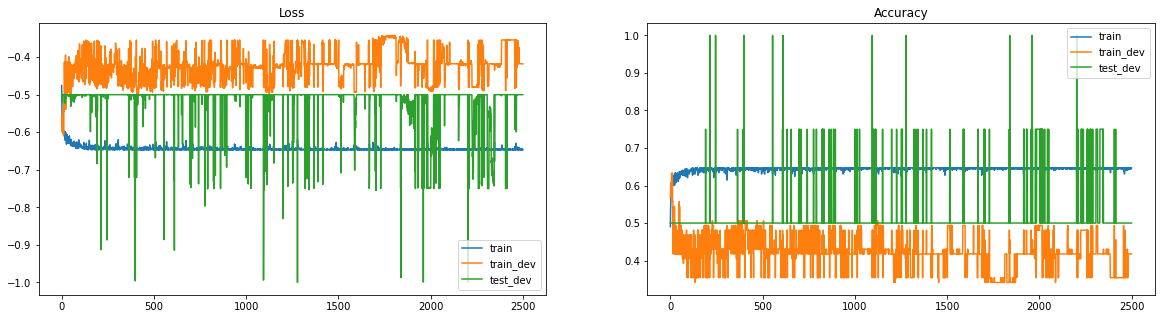

8_2_1_4_0.002


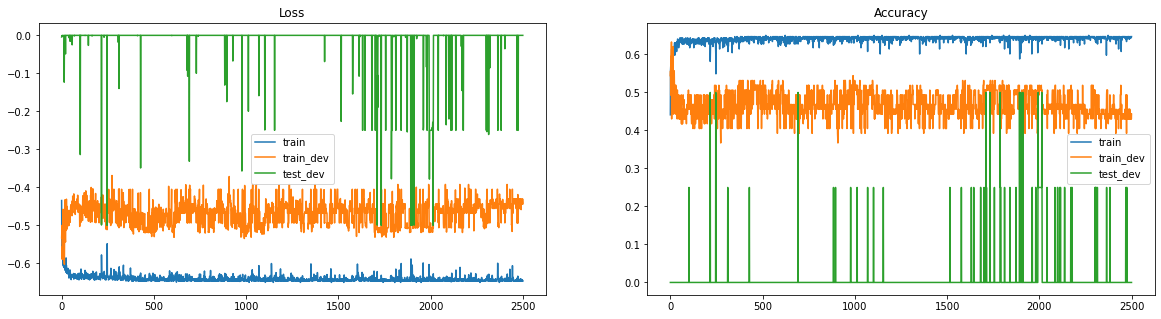

32_1_0_256_0.0002


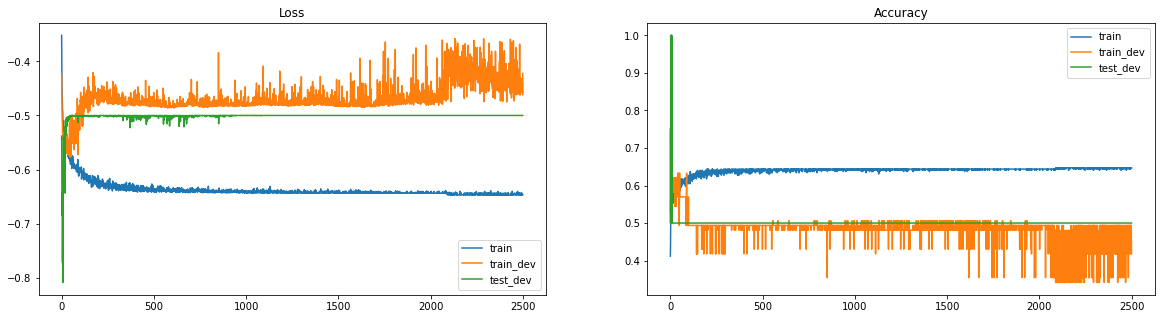

In [276]:
for i in ['8_2_1_256_2e-06','8_2_0_256_0.002','8_2_0_64_0.002','8_2_1_4_0.002','32_1_0_256_0.0002']:
    print(i)
    plot_training('../../1_Data/3_Trained_classifier/'+i+'/')
    plt.show()

# Understanding the potential problems (input, etc.)

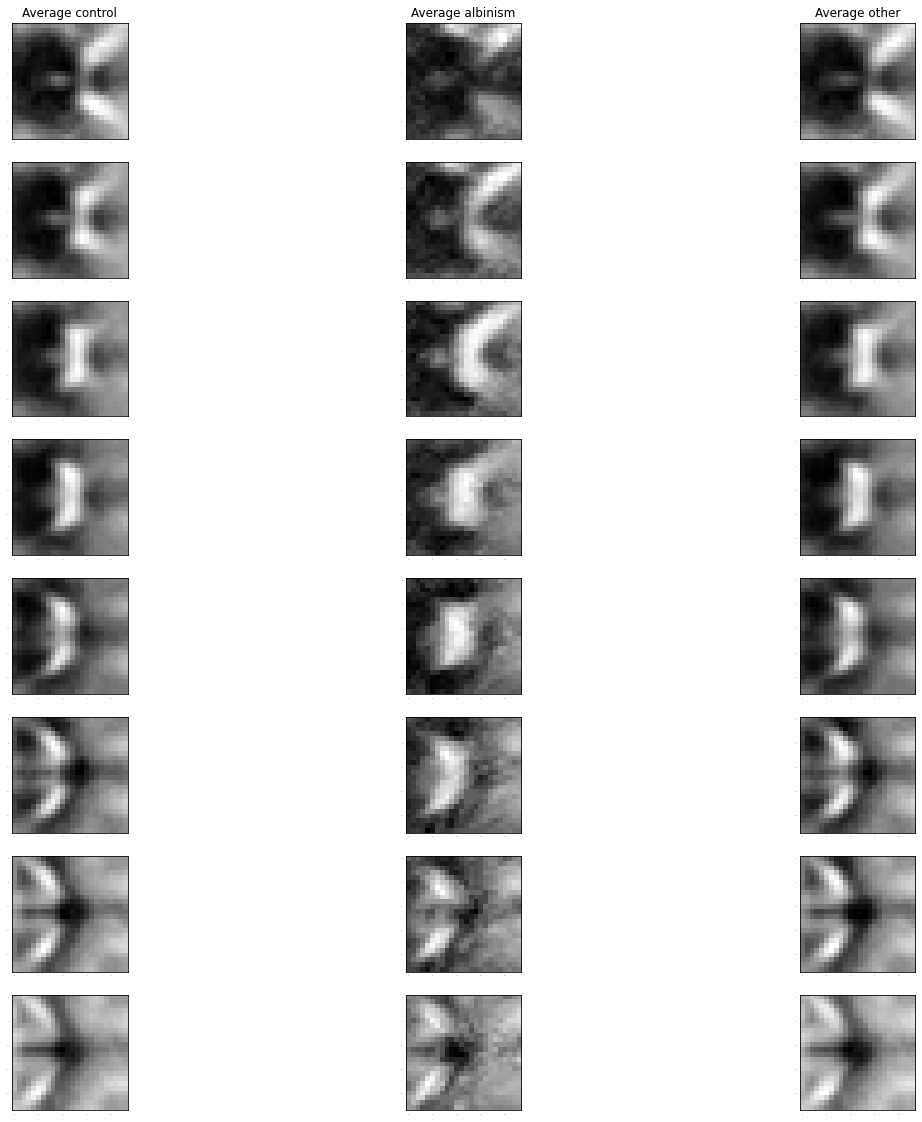

In [400]:
# Calculate average input

average_control=np.zeros((24,24,8))
average_albinism = np.zeros((24,24,8))
average_other = np.zeros((24,24,8))

for batch in dataloaders_chiasm['train']:    
    average_control+=np.sum(np.array(batch['chiasm']['data'])[batch['label'].numpy()==0], axis=(0,1))
    average_albinism+=np.sum(np.array(batch['chiasm']['data'])[batch['label'].numpy()==1], axis=(0,1))
    average_other+=np.sum(np.array(batch['chiasm']['data'])[batch['label'].numpy()==2], axis=(0,1))

plt.figure(figsize=(20,20))

for i in range(8):
        
    # Control
    plt.subplot(8,3,3*i+1)
    plt.imshow(average_control[:,:,i], cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Average control')
    
    # Albinism
    plt.subplot(8,3,3*i+2)
    plt.imshow(average_albinism[:,:,i], cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Average albinism')
    
    # Other
    plt.subplot(8,3,3*i+3)
    plt.imshow(average_other[:,:,i], cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Average other')

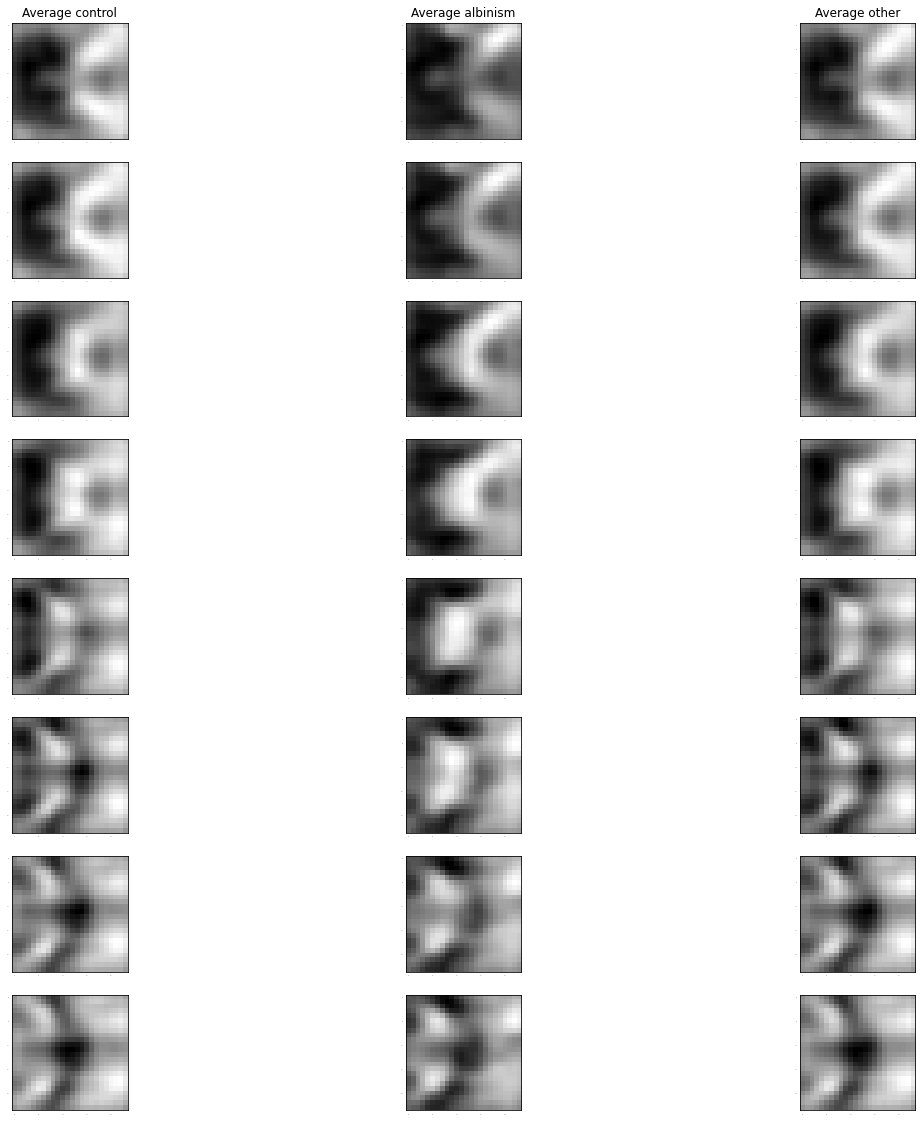

In [416]:
# Calculate average input after AE step

ae = UNet(1,1,8,2)
ae.load_state_dict(torch.load('../../1_Data/2_Trained_AE/8_2/optimal_weights'))

average_control=np.zeros((24,24,8))
average_albinism = np.zeros((24,24,8))
average_other = np.zeros((24,24,8))

for batch in dataloaders_chiasm['train']:  
                              
    output = ae(batch['chiasm']['data']).detach().numpy()                
                                                       
    average_control+=np.sum(output[batch['label'].numpy()==0], axis=(0,1))
    average_albinism+=np.sum(output[batch['label'].numpy()==1], axis=(0,1))
    average_other+=np.sum(output[batch['label'].numpy()==2], axis=(0,1))

plt.figure(figsize=(20,20))

for i in range(8):
        
    # Control
    plt.subplot(8,3,3*i+1)
    plt.imshow(average_control[:,:,i], cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Average control')
    
    # Albinism
    plt.subplot(8,3,3*i+2)
    plt.imshow(average_albinism[:,:,i], cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Average albinism')
    
    # Other
    plt.subplot(8,3,3*i+3)
    plt.imshow(average_other[:,:,i], cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Average other')

Control


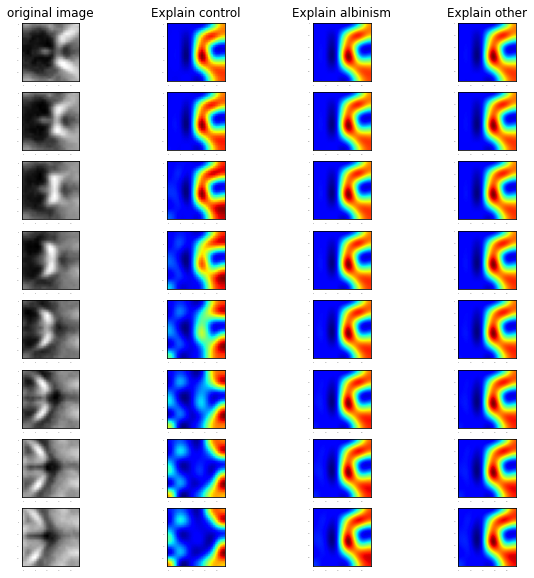

albinism


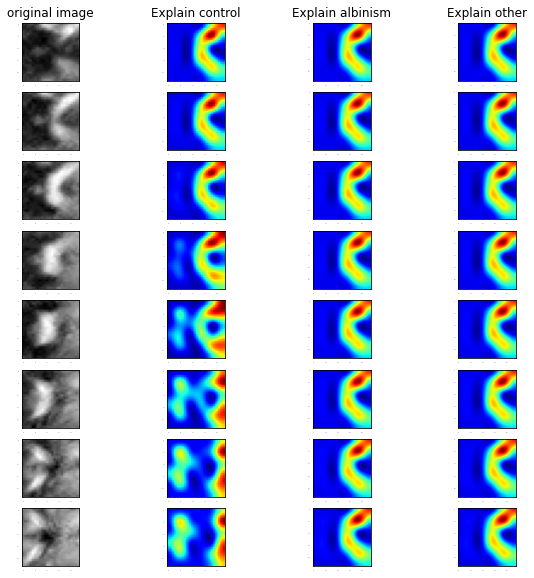

albinism


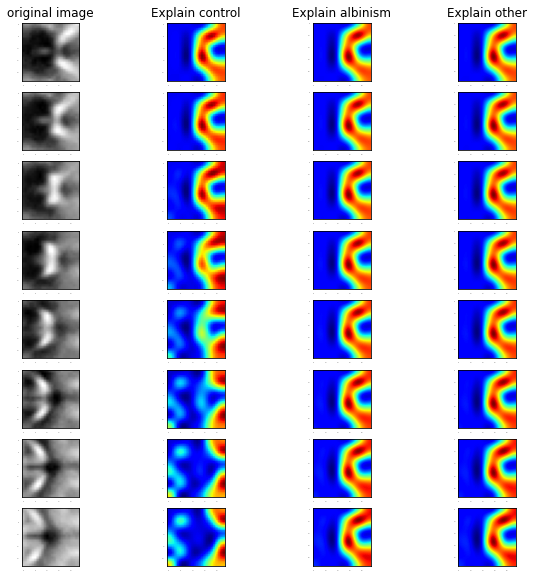

In [440]:
# GradCAM for initial input

# Calculate average input
average_control=np.zeros((24,24,8))
average_albinism = np.zeros((24,24,8))
average_other = np.zeros((24,24,8))

for batch in dataloaders_chiasm['train']:    
    average_control+=np.sum(np.array(batch['chiasm']['data'])[batch['label'].numpy()==0], axis=(0,1))
    average_albinism+=np.sum(np.array(batch['chiasm']['data'])[batch['label'].numpy()==1], axis=(0,1))
    average_other+=np.sum(np.array(batch['chiasm']['data'])[batch['label'].numpy()==2], axis=(0,1))
    
# Initialize model
model = Classify_chiasm(8,2,0,64)
model.load_state_dict(torch.load('../../1_Data/3_Trained_classifier/8_2_0_64_0.002/optimal_weights'))

# Plots for control
print('Control')

explain_control = model.gradcam(torch.from_numpy(average_control).unsqueeze(0).unsqueeze(0).float(),0)
explain_control = zoom(explain_control,(4,4,4))

explain_albinism = model.gradcam(torch.from_numpy(average_control).unsqueeze(0).unsqueeze(0).float(),1)
explain_albinism = zoom(explain_control,(4,4,4))

explain_other = model.gradcam(torch.from_numpy(average_control).unsqueeze(0).unsqueeze(0).float(),2)
explain_other = zoom(explain_control,(4,4,4))

plt.figure(figsize=(10,10))
for i in range(8):

    # Original image
    plt.subplot(8,4,4*i+1)
    plt.imshow(average_control[:,:,i], cmap='gray', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('original image');

    # Explain control
    plt.subplot(8,4,4*i+2)
    plt.imshow(explain_control[:,:,i], cmap='jet', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Explain control');
        
    # Explain albinism
    plt.subplot(8,4,4*i+3)
    plt.imshow(explain_albinism[:,:,i], cmap='jet', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Explain albinism');
        
    # Explain other
    plt.subplot(8,4,4*i+4)
    plt.imshow(explain_other[:,:,i], cmap='jet', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Explain other');
        
plt.show()
        
# Plots for albinism
print('albinism')

explain_control = model.gradcam(torch.from_numpy(average_albinism).unsqueeze(0).unsqueeze(0).float(),0)
explain_control = zoom(explain_control,(4,4,4))

explain_albinism = model.gradcam(torch.from_numpy(average_albinism).unsqueeze(0).unsqueeze(0).float(),1)
explain_albinism = zoom(explain_control,(4,4,4))

explain_other = model.gradcam(torch.from_numpy(average_albinism).unsqueeze(0).unsqueeze(0).float(),2)
explain_other = zoom(explain_control,(4,4,4))

plt.figure(figsize=(10,10))
for i in range(8):

    # Original image
    plt.subplot(8,4,4*i+1)
    plt.imshow(average_albinism[:,:,i], cmap='gray', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('original image');

    # Explain control
    plt.subplot(8,4,4*i+2)
    plt.imshow(explain_control[:,:,i], cmap='jet', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Explain control');
        
    # Explain albinism
    plt.subplot(8,4,4*i+3)
    plt.imshow(explain_albinism[:,:,i], cmap='jet', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Explain albinism');
        
    # Explain other
    plt.subplot(8,4,4*i+4)
    plt.imshow(explain_other[:,:,i], cmap='jet', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Explain other');

plt.show()

  
# Plots for other
print('other')

explain_control = model.gradcam(torch.from_numpy(average_other).unsqueeze(0).unsqueeze(0).float(),0)
explain_control = zoom(explain_control,(4,4,4))

explain_albinism = model.gradcam(torch.from_numpy(average_other).unsqueeze(0).unsqueeze(0).float(),1)
explain_albinism = zoom(explain_control,(4,4,4))

explain_other = model.gradcam(torch.from_numpy(average_other).unsqueeze(0).unsqueeze(0).float(),2)
explain_other = zoom(explain_control,(4,4,4))

plt.figure(figsize=(10,10))
for i in range(8):

    # Original image
    plt.subplot(8,4,4*i+1)
    plt.imshow(average_other[:,:,i], cmap='gray', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('original image');

    # Explain control
    plt.subplot(8,4,4*i+2)
    plt.imshow(explain_control[:,:,i], cmap='jet', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Explain control');
        
    # Explain albinism
    plt.subplot(8,4,4*i+3)
    plt.imshow(explain_albinism[:,:,i], cmap='jet', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Explain albinism');
        
    # Explain other
    plt.subplot(8,4,4*i+4)
    plt.imshow(explain_other[:,:,i], cmap='jet', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Explain other');

plt.show()

## Input that maximizes outcome

In [277]:
def maximizing_input(folder_with_networks, num_steps = 1000):
    
    networks = [os.path.basename(x[0]) for x in os.walk(folder_with_networks)]
    networks=networks[1:] #[1:]
    
    for network in networks:
        
        # Create network and load the weights
        params=network.split('_')

        model = Classify_chiasm(int(params[0]),int(params[1]),int(params[2]),int(params[3]))
        model.load_state_dict(torch.load(folder_with_networks+network+'/optimal_weights'))
        model.requires_grad_(False);
        
        print(network)
        
        # Control
        x = torch.nn.Parameter(torch.rand(1,1,24,24,8, dtype=float), requires_grad=True) 
        x_saved = x.clone().detach()
        
        optim = torch.optim.Adam([x], lr=100)
        mse = torch.nn.MSELoss()
        y = torch.tensor(np.array([1,0,0]), dtype=float)
        
        for _ in range(num_steps):
            loss = mse(model(x.float()), y.float())
            loss.backward()
            optim.step()
            optim.zero_grad()
                
        # Thresholded difference
        fig = plt.figure(figsize=(20,6))

        threshold = 0# np.percentile(x.detach().numpy(),80)

        for i in range(x.detach().numpy().shape[4]):

            plt.subplot(2,x.detach().numpy().shape[4],i+1);
            plt.imshow(x.detach().numpy()[0,0,:,:,i]>threshold, cmap='gray')
            
            if i==0:
                plt.ylabel('Control thresholded')  
            
        #plt.pause(0.05)
        
        plt.show()
        
        # Albinism
        x = torch.nn.Parameter(torch.rand(1,1,24,24,8, dtype=float), requires_grad=True) 
        x_saved = x.clone().detach()
        
        optim = torch.optim.Adam([x], lr=100)
        mse = torch.nn.MSELoss()
        y = torch.tensor(np.array([0,1,0]), dtype=float)
        
        for _ in range(num_steps):
            loss = mse(model(x.float()), y.float())
            loss.backward()
            optim.step()
            optim.zero_grad()
                
        # Thresholded difference
        fig = plt.figure(figsize=(20,6))

        threshold = 0#np.percentile(x.detach().numpy(),80)

        for i in range(x.detach().numpy().shape[4]):

            plt.subplot(2,x.detach().numpy().shape[4],i+1);
            plt.imshow(x.detach().numpy()[0,0,:,:,i]>threshold, cmap='gray')
            
            if i==0:
                plt.ylabel('Albinism thresholded')  
            
        #plt.pause(0.05)
        
        plt.show()

32_1_0_256_0.0002


Using a target size (torch.Size([3])) that is different to the input size (torch.Size([1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


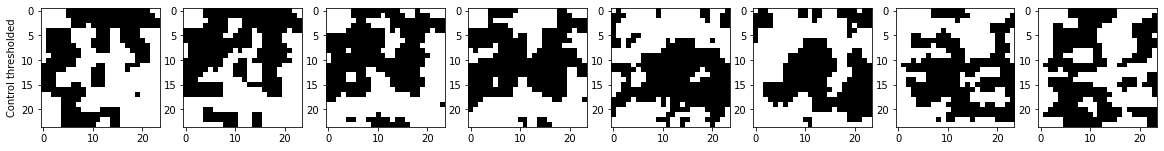

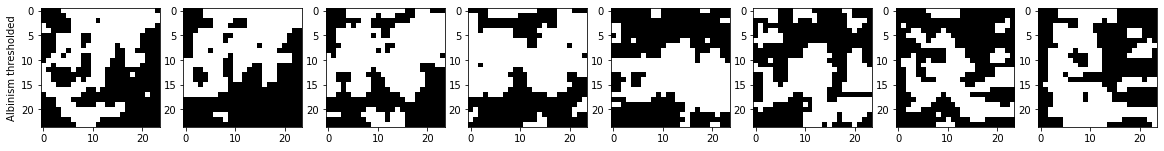

8_2_0_4_2e-06


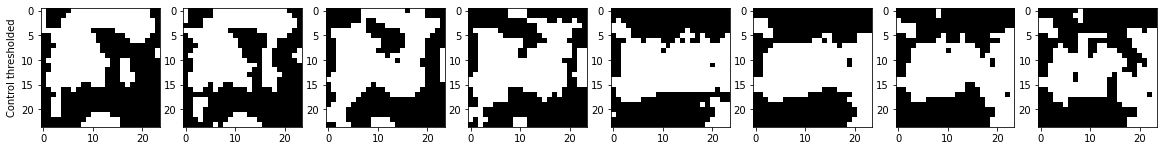

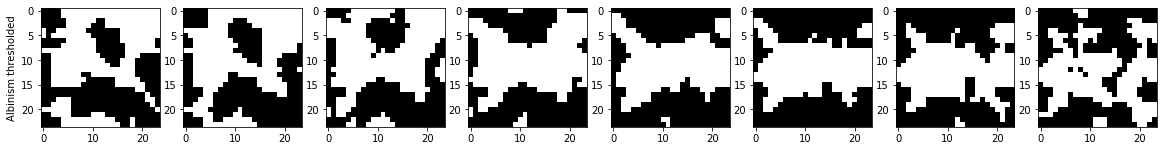

32_1_0_64_0.0002


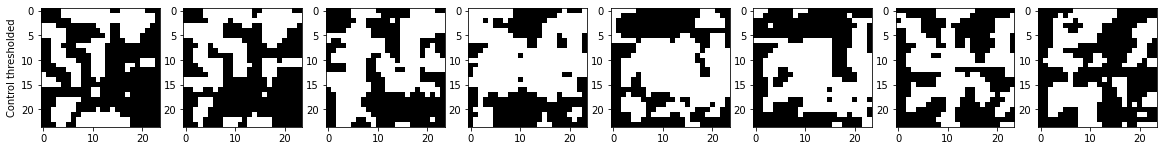

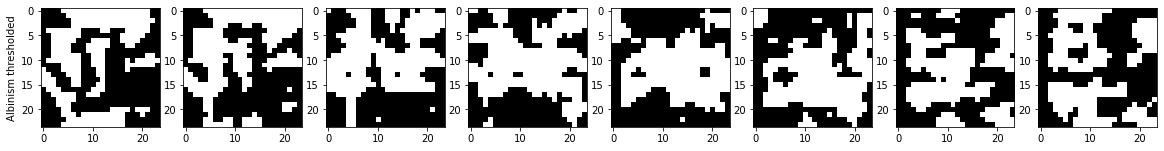

32_1_0_4_2e-05


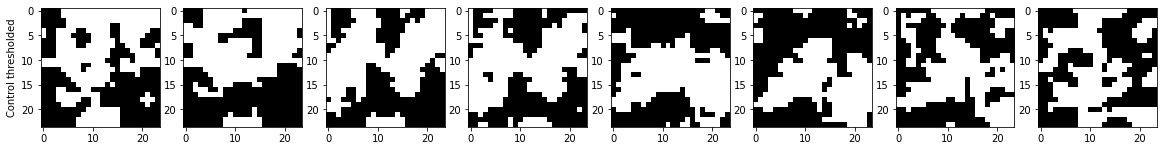

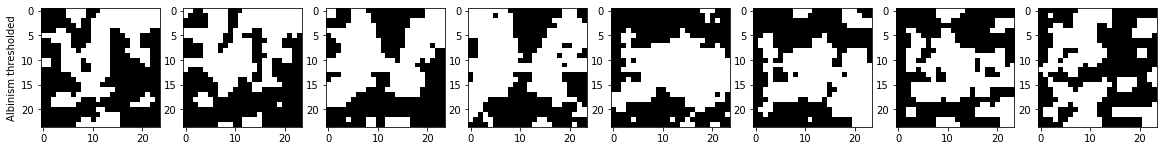

32_1_1_4_0.0002


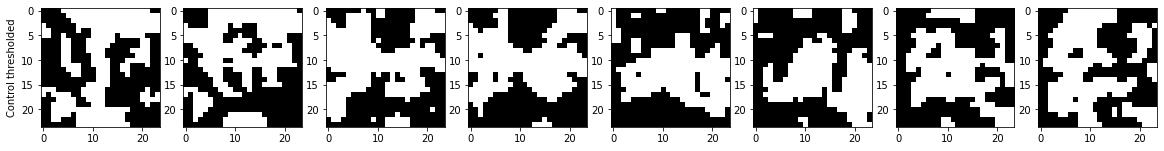

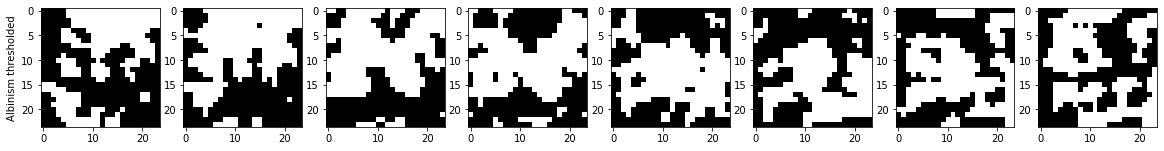

32_1_0_256_0.002


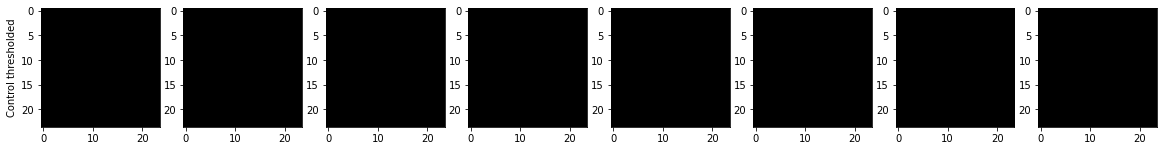

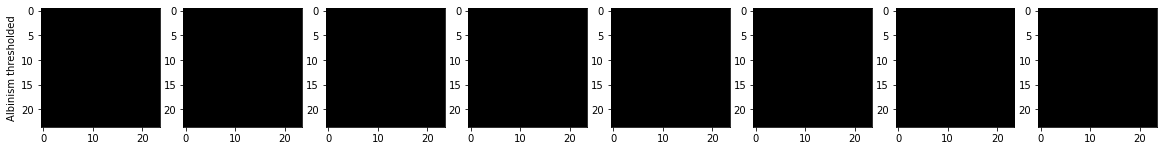

8_2_1_64_2e-06


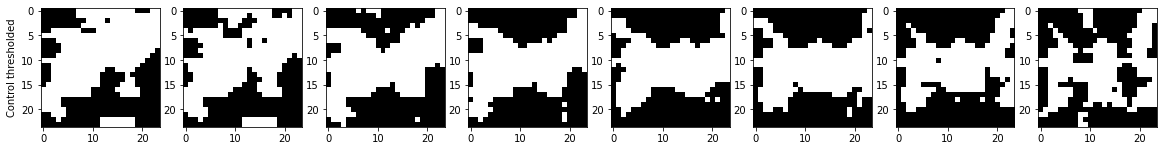

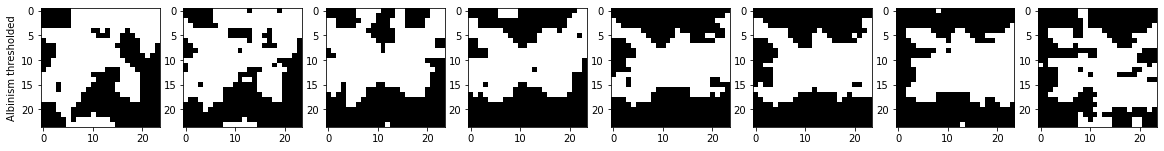

32_1_1_256_0.0002


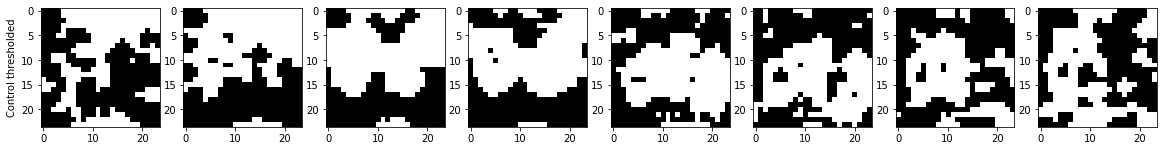

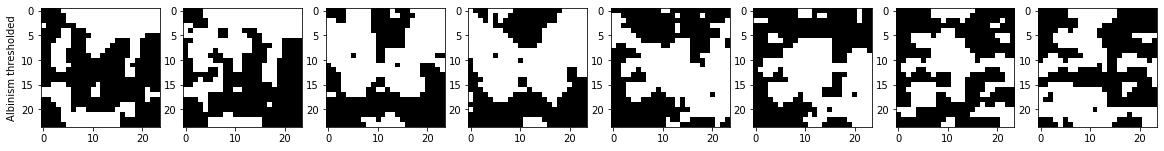

8_2_0_256_0.0002


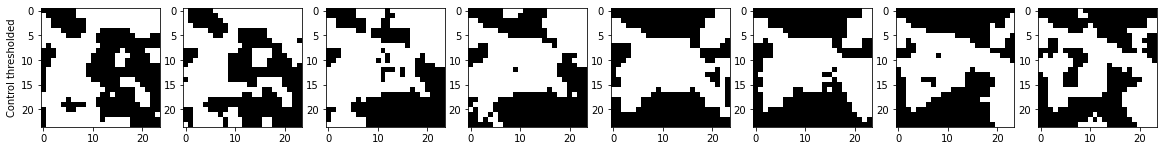

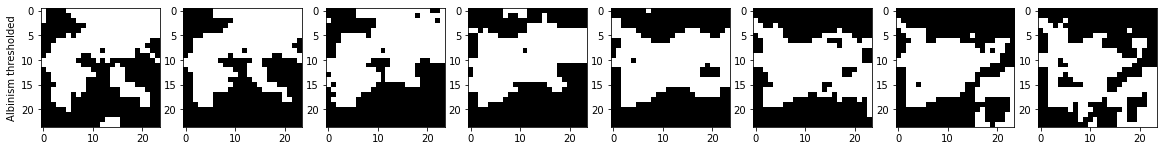

32_1_0_4_2e-06


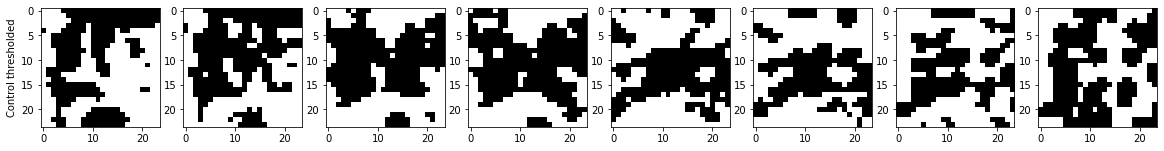

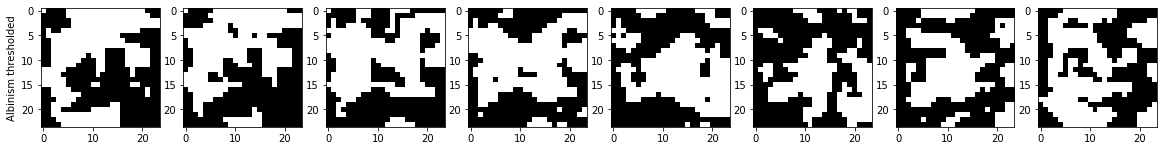

8_2_0_64_0.0002


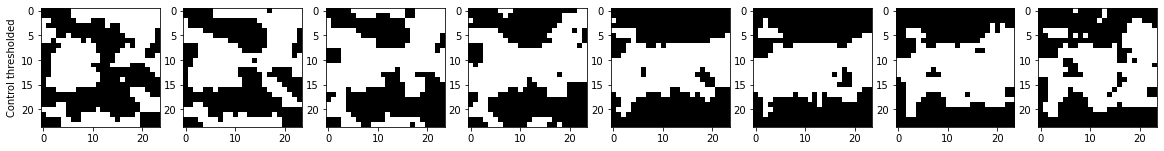

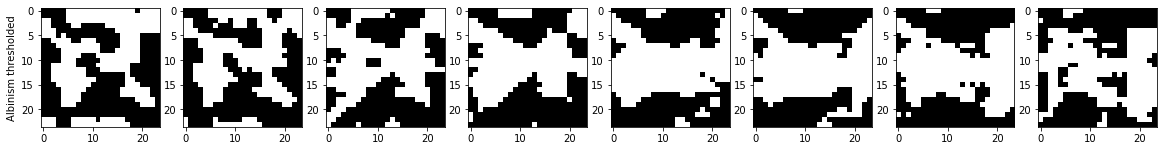

8_2_1_256_0.0002


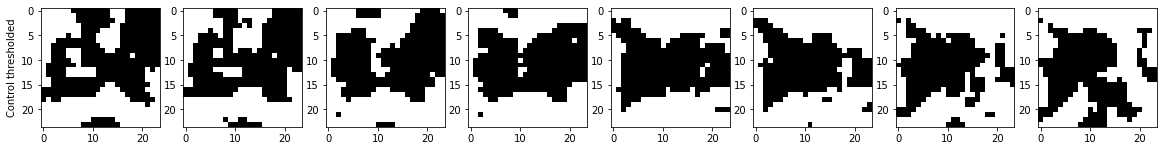

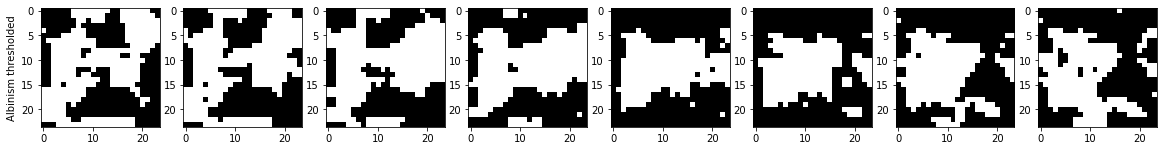

32_1_1_64_0.0002


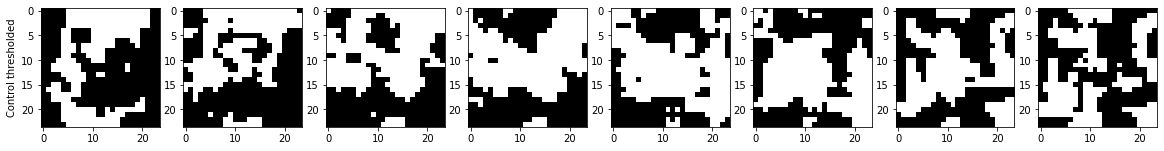

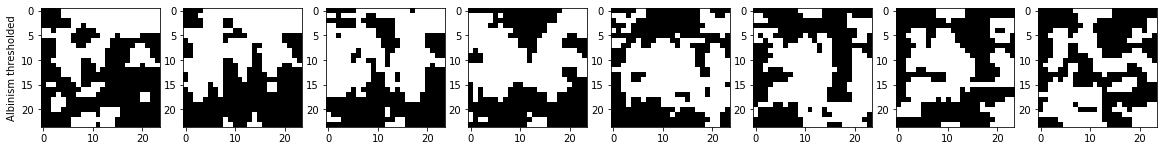

8_2_0_4_2e-05


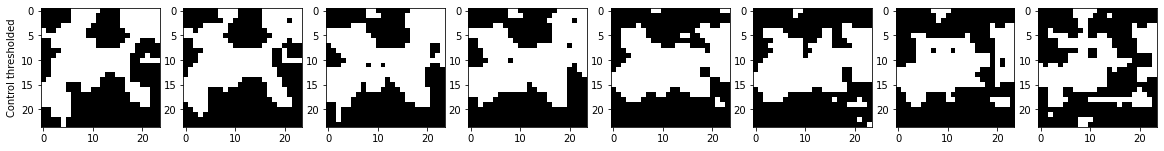

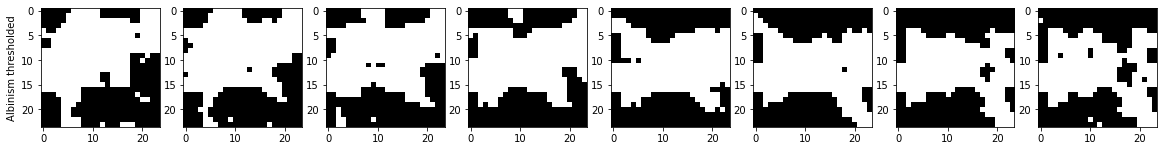

8_2_1_4_2e-05


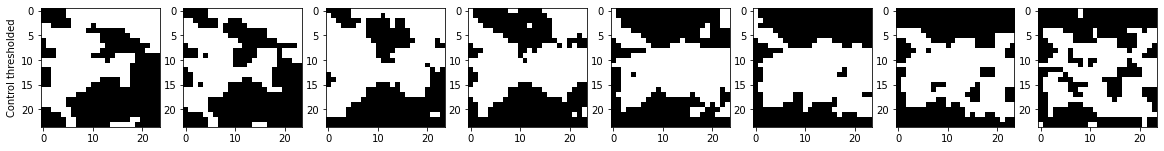

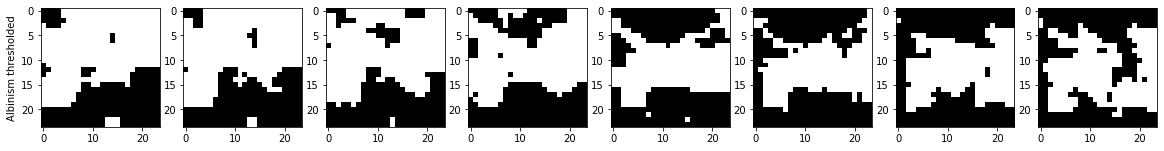

32_1_1_64_2e-05


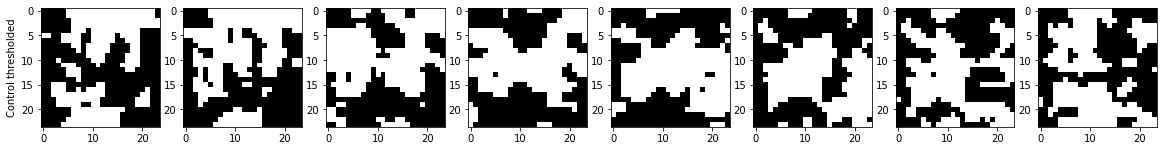

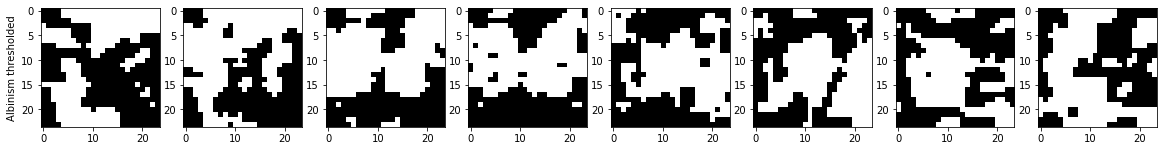

8_2_1_256_2e-05


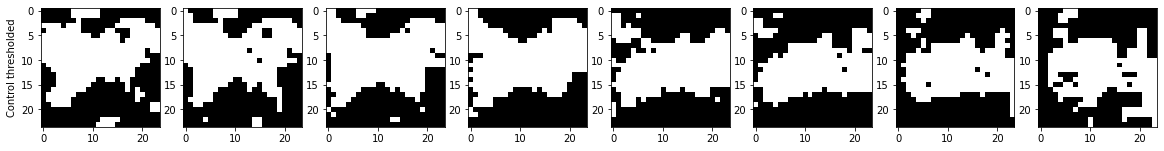

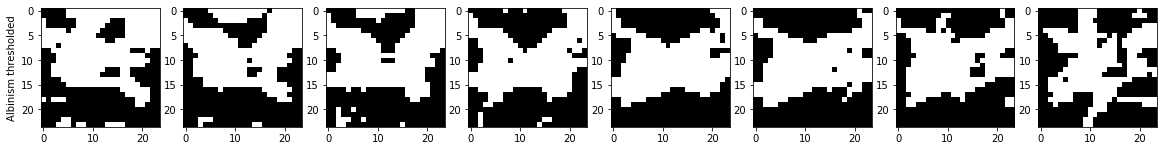

8_2_0_64_2e-06


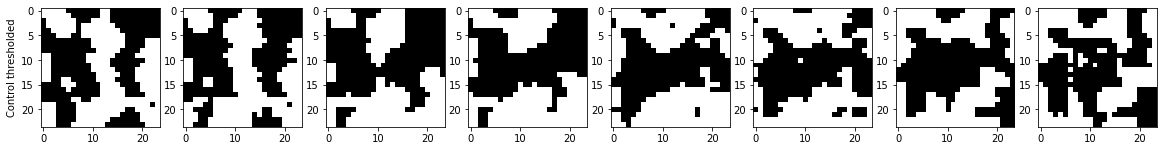

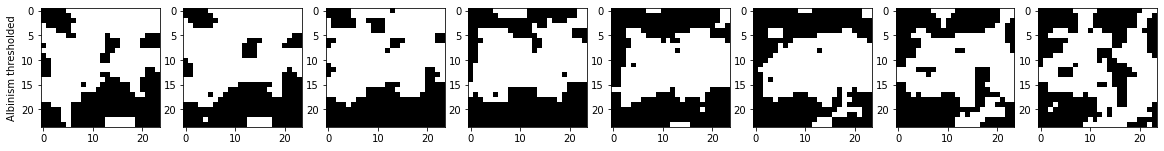

32_1_0_4_0.0002


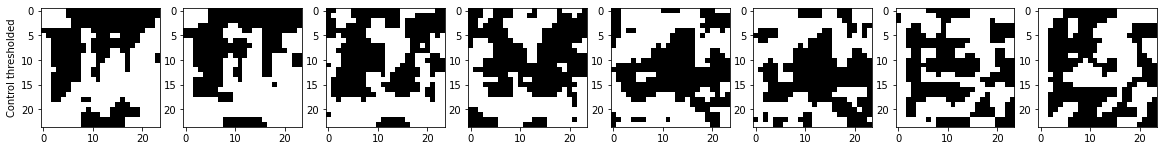

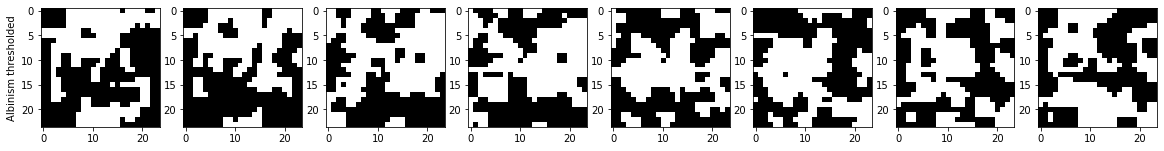

8_2_1_4_2e-06


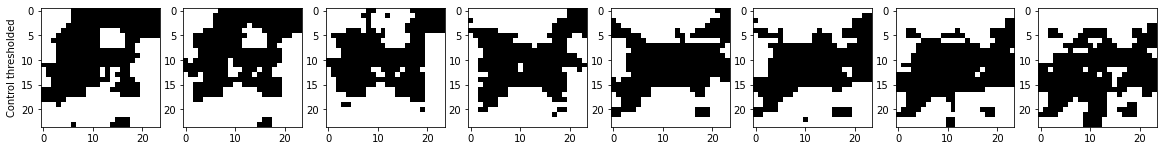

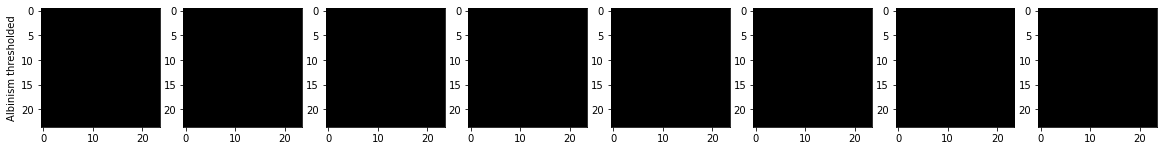

32_1_1_4_2e-05


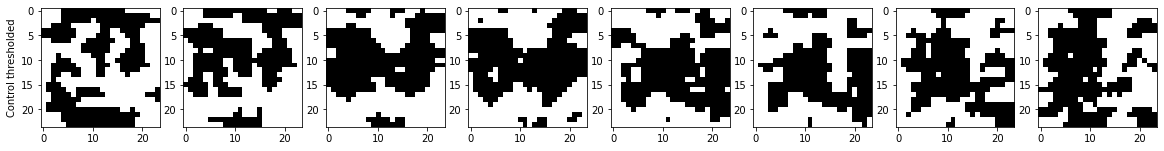

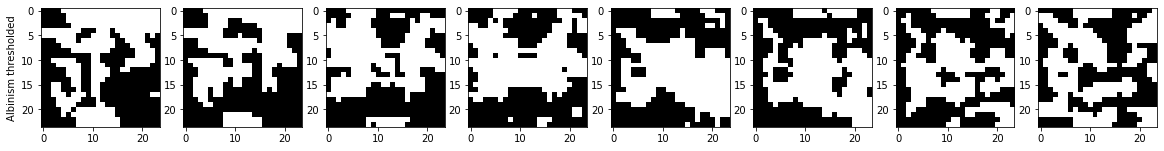

8_2_1_4_0.0002


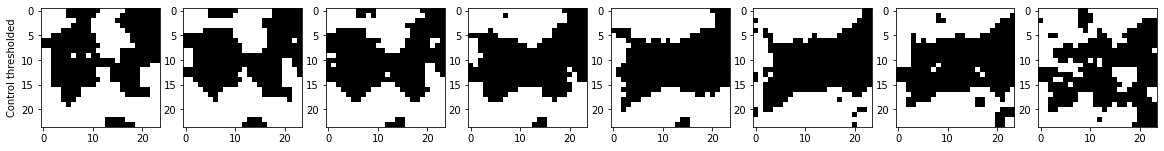

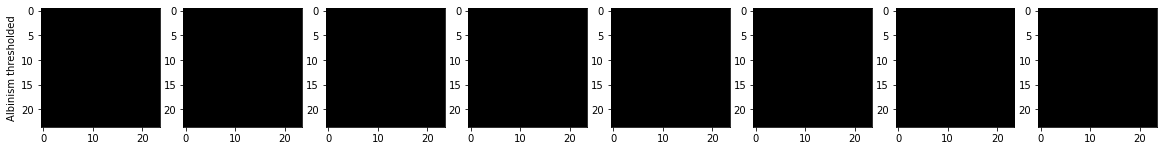

32_1_1_4_0.002


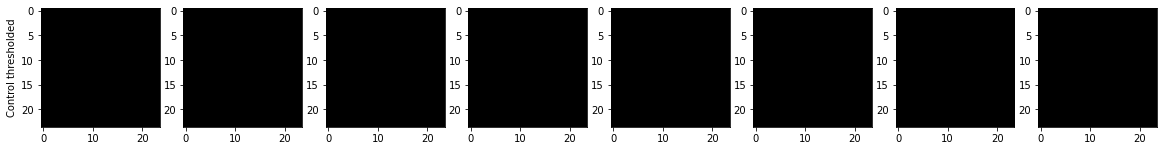

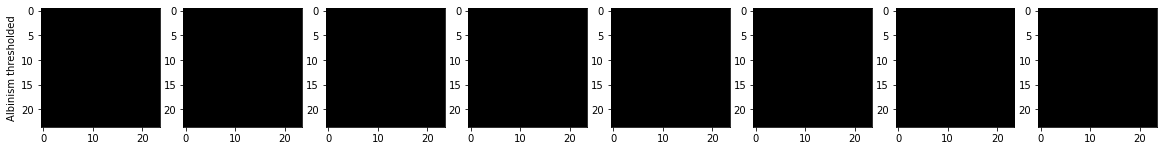

8_2_0_256_2e-05


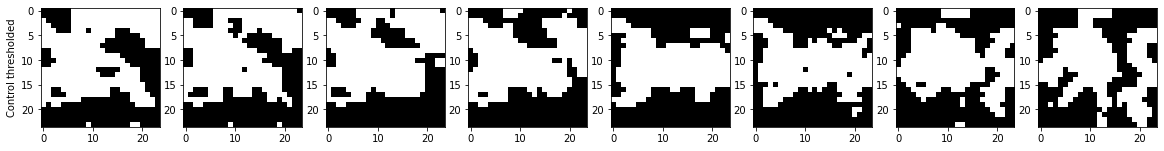

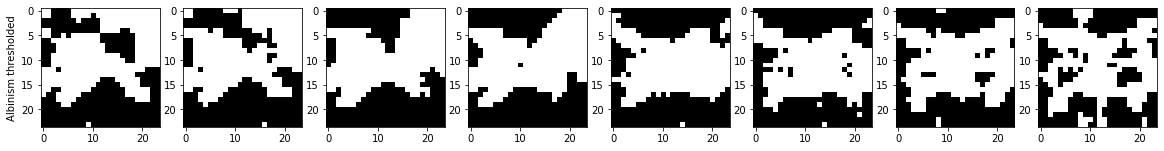

8_2_1_64_2e-05


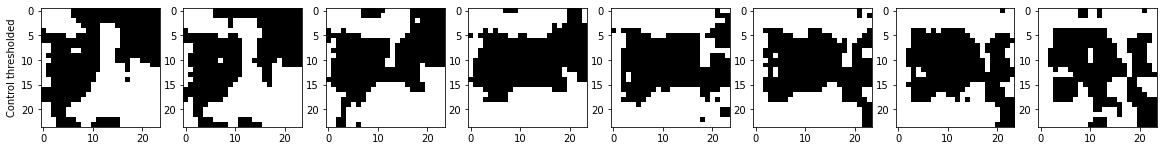

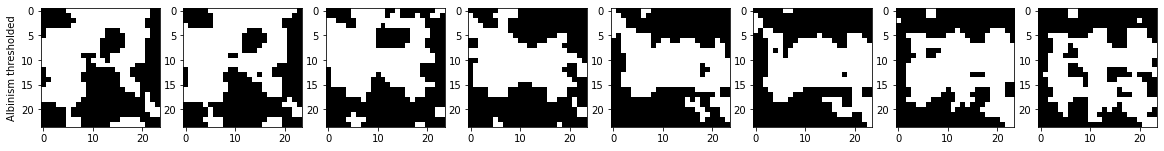

32_1_0_64_2e-06


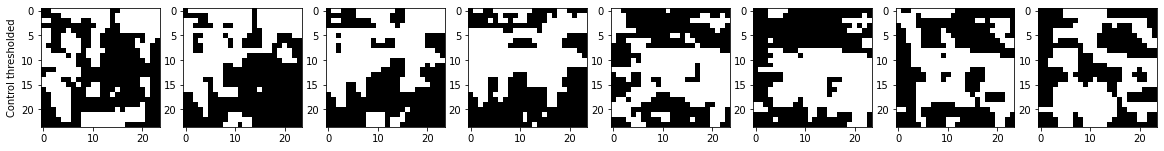

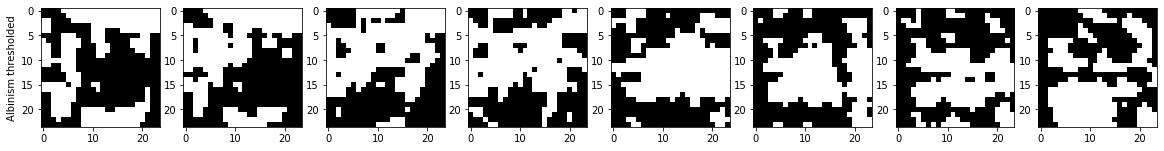

32_1_0_256_2e-06


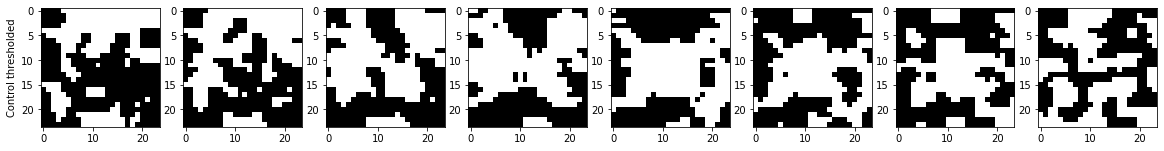

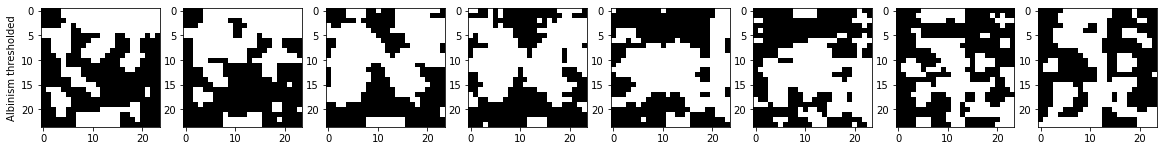

32_1_1_64_0.002


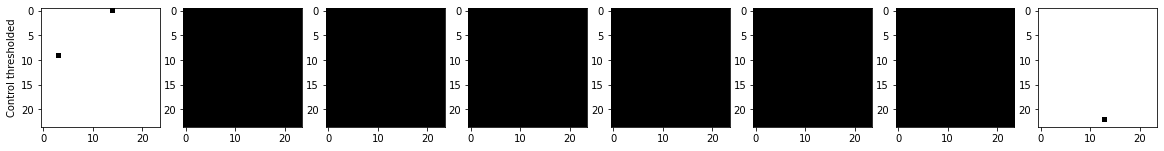

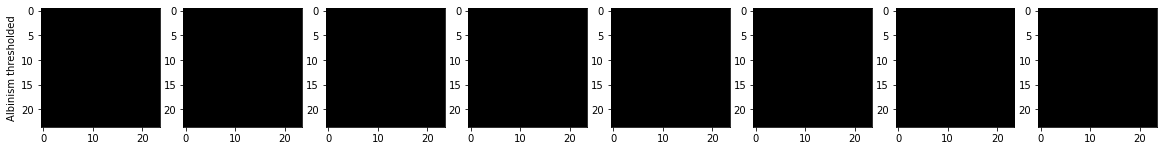

8_2_0_4_0.002


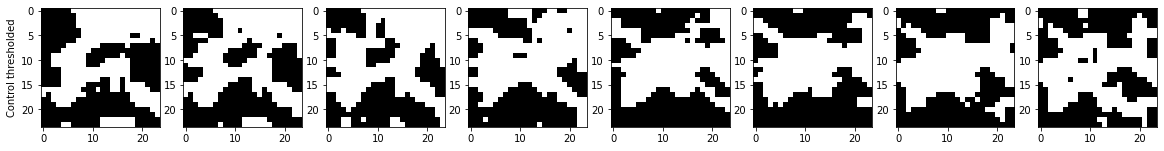

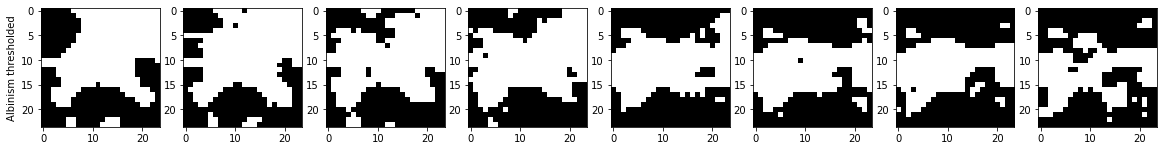

8_2_1_256_0.002


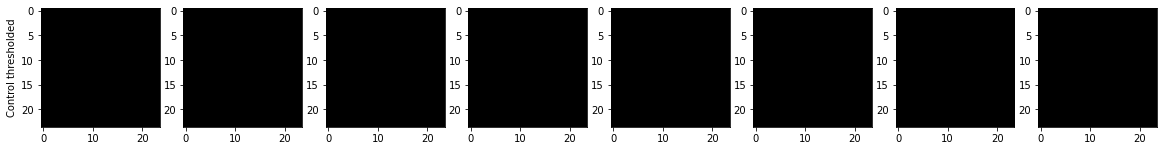

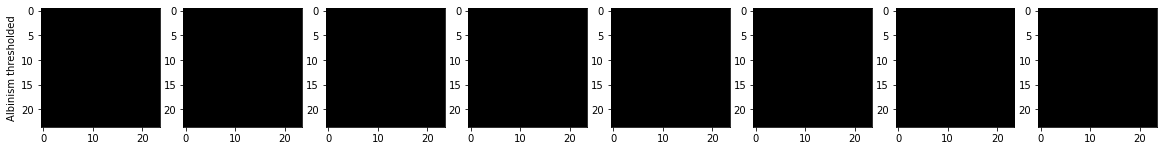

32_1_1_256_2e-06


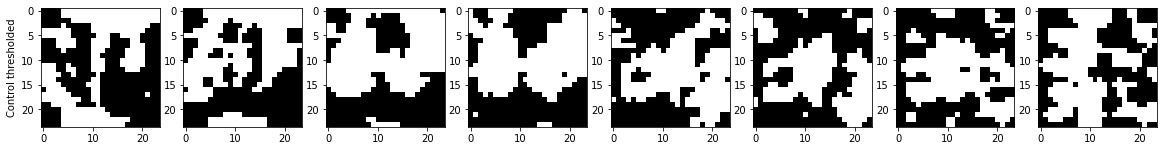

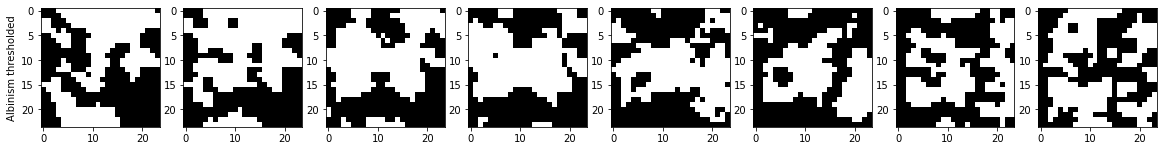

32_1_0_64_2e-05


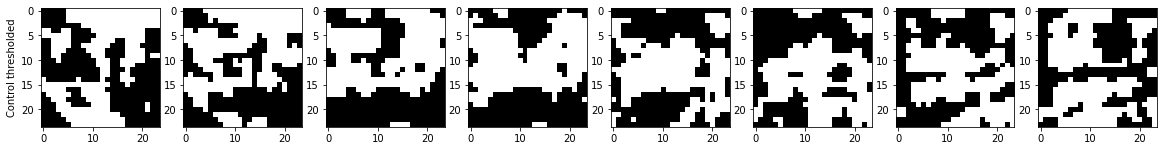

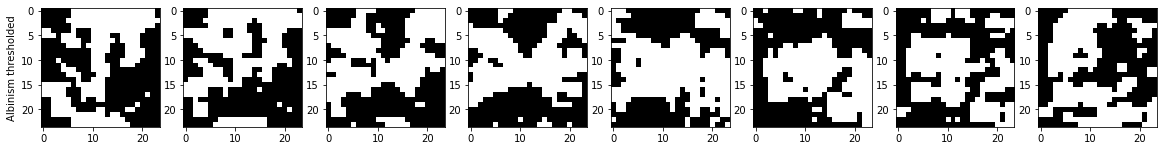

8_2_1_256_2e-06


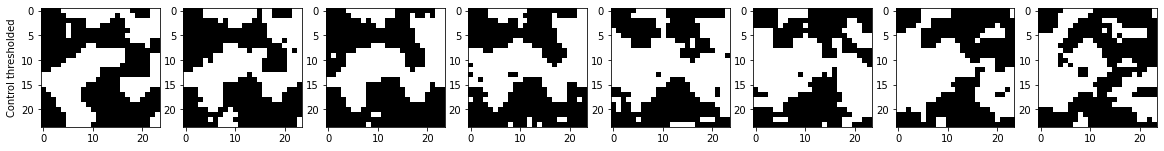

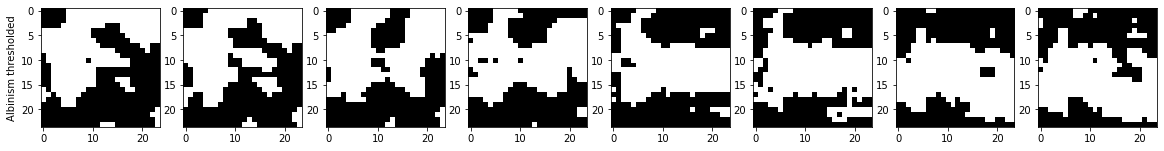

32_1_1_256_0.002


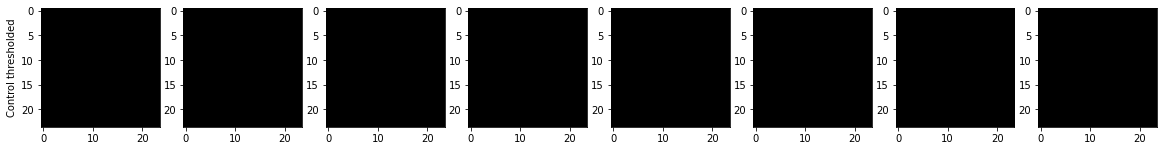

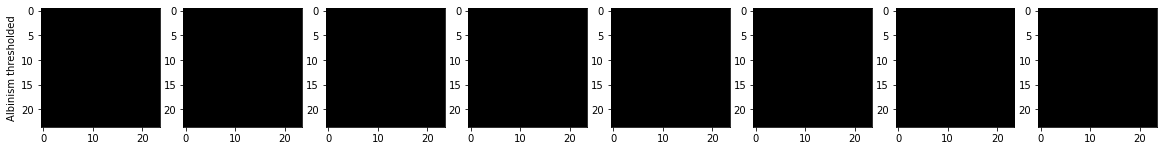

32_1_0_64_0.002


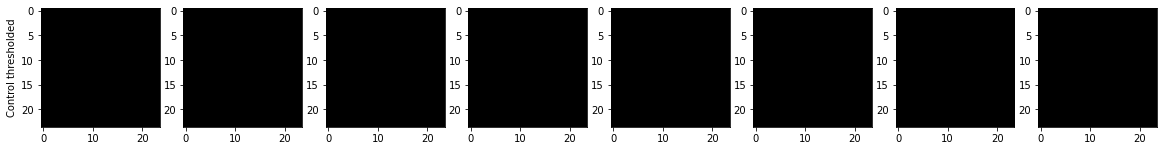

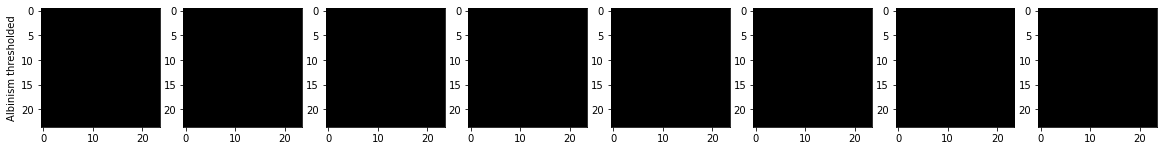

8_2_0_64_2e-05


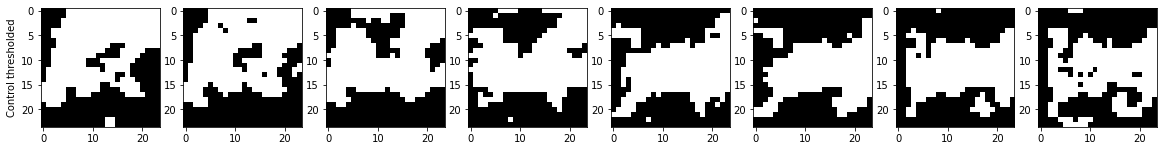

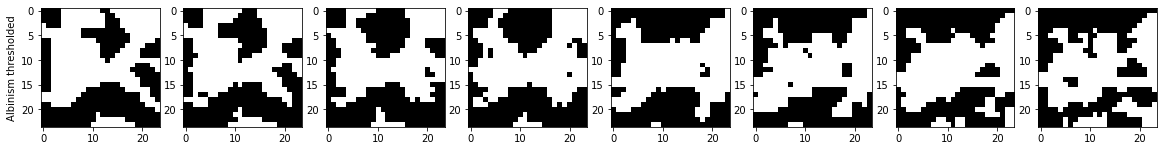

32_1_1_4_2e-06


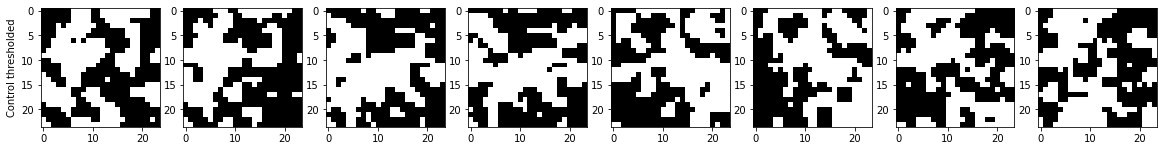

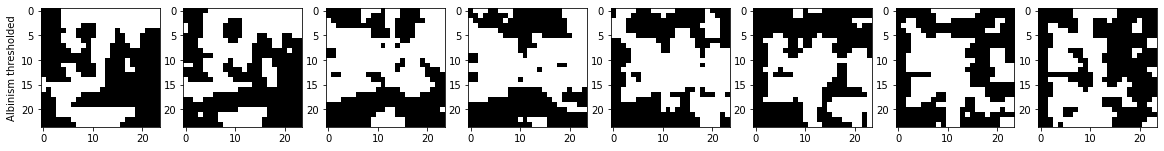

8_2_0_4_0.0002


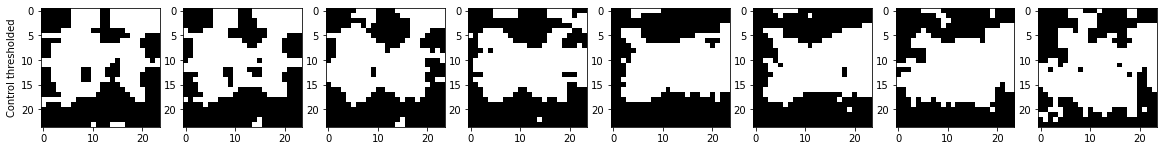

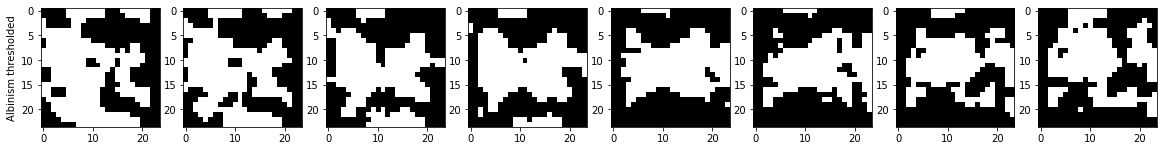

8_2_1_64_0.002


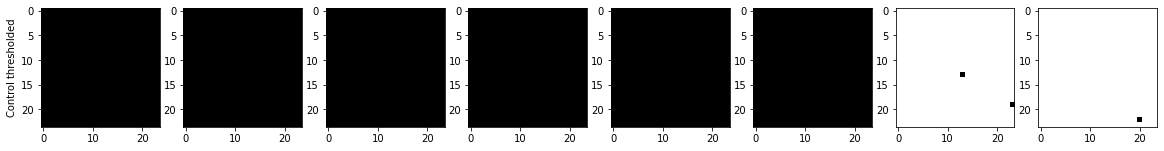

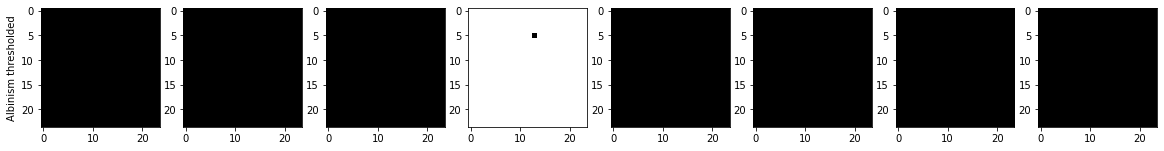

8_2_0_256_0.002


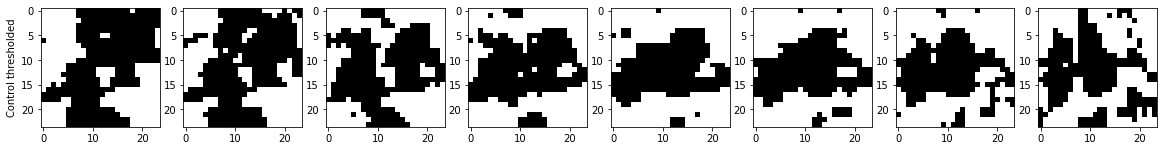

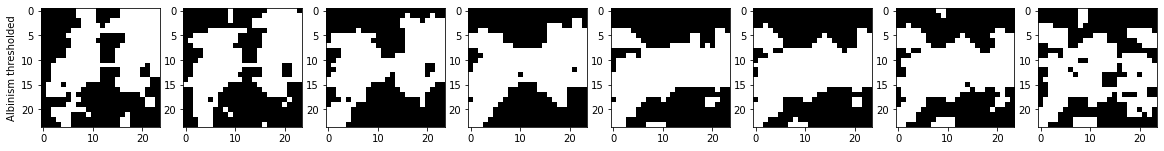

32_1_1_64_2e-06


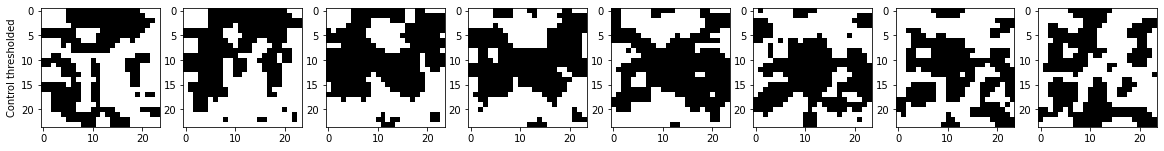

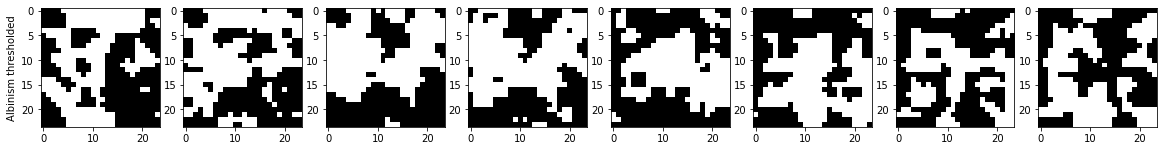

8_2_0_64_0.002


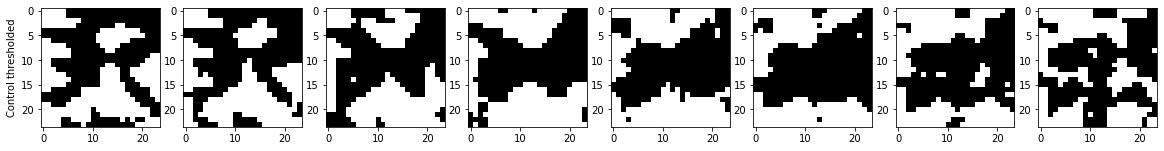

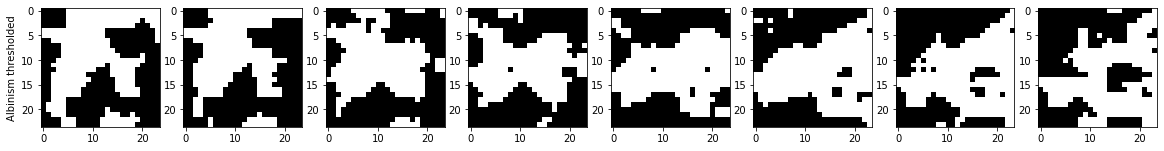

8_2_1_4_0.002


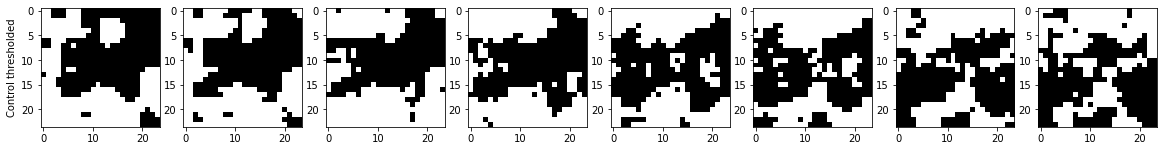

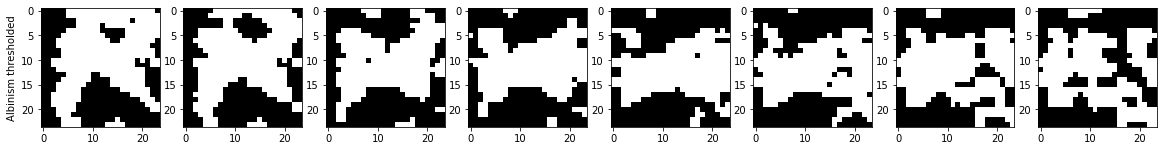

8_2_1_64_0.0002


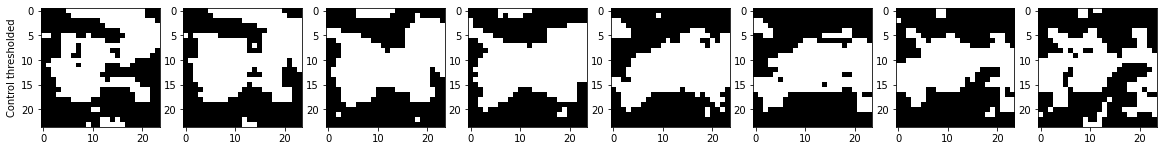

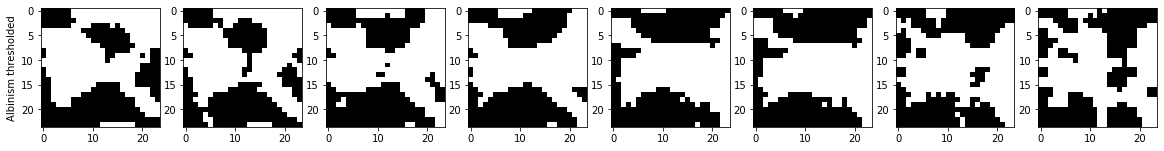

32_1_0_256_2e-05


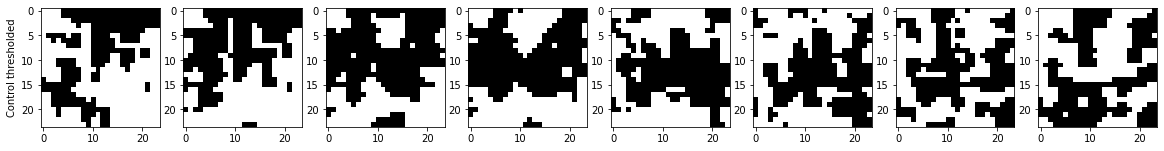

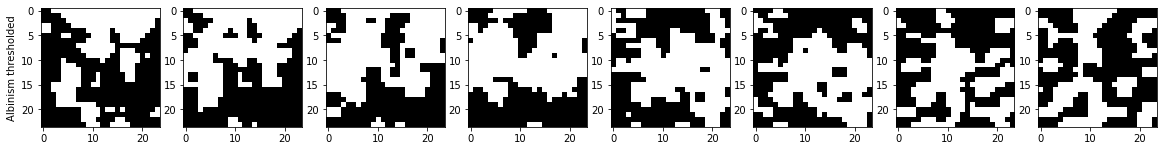

32_1_1_256_2e-05


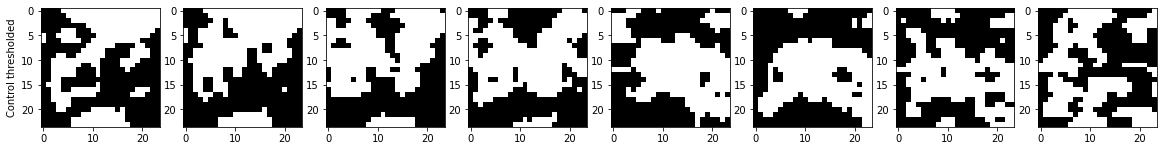

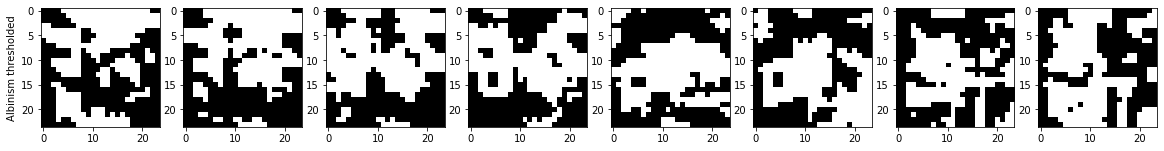

32_1_0_4_0.002


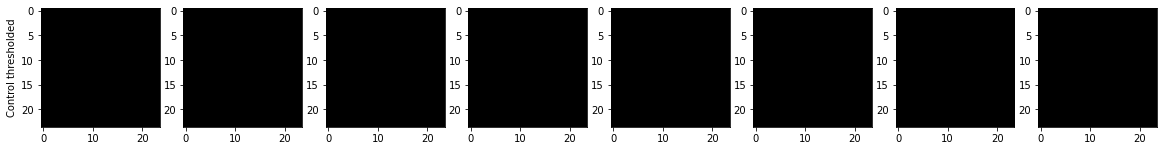

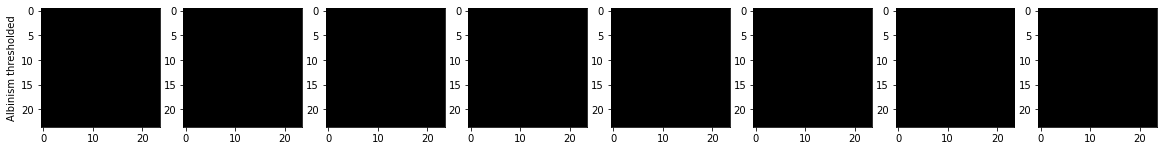

8_2_0_256_2e-06


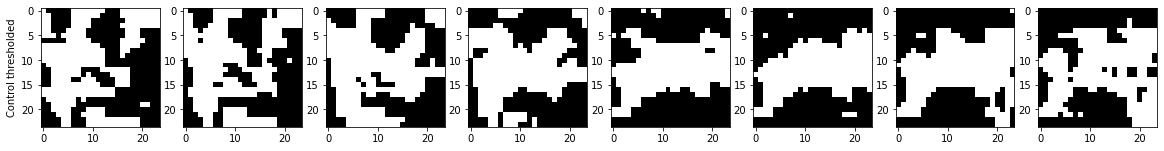

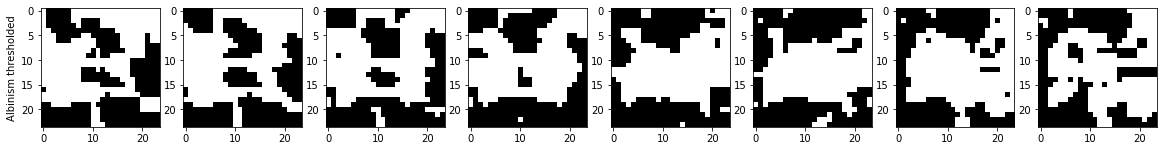

In [278]:
maximizing_input('../../1_Data/3_Trained_classifier/')

# Explanation

## GradCAM

0.75
Predicted:  tensor([0, 0, 0, 1])
True:  tensor([1, 0, 0, 1])
torch.Size([1, 32, 6, 6, 2])


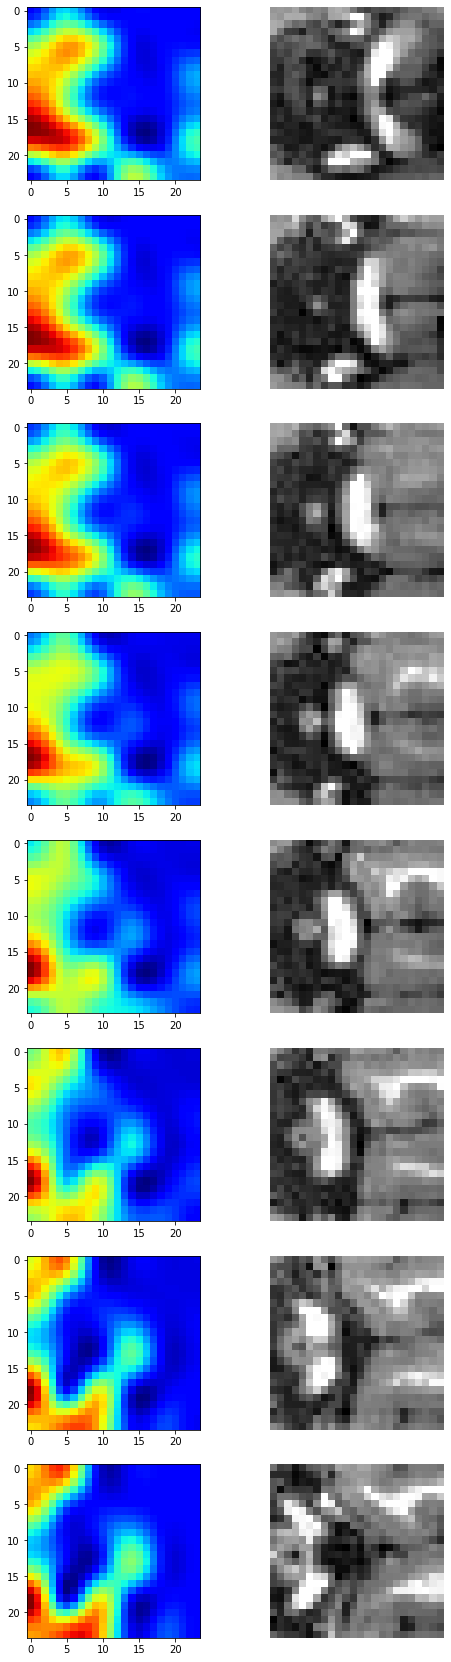

In [163]:
model=Classify_chiasm(8,2,0,64)
model.load_state_dict(torch.load('../../1_Data/3_Trained_classifier/8_2_0_64_2e-06/optimal_weights'))

#for batch in dataloaders_chiasm['dev_train']:
#    print('ok!')

#batch=next(enumerate(dataloaders_chiasm['dev_test']))[1]
    
prediction = model(batch['chiasm']['data'])

print(accuracy_score(batch['label'],prediction.cpu().argmax(dim=1)))

print('Predicted: ',prediction.cpu().argmax(dim=1))
print('True: ',(batch['label']))

image = 0
class_to_be_explained=1

example= batch['chiasm']['data'][image:(image+1)]

# For the first control
explanation = model.gradcam(example,class_to_be_explained) 

explanation_resampled = zoom(explanation, (4, 4, 4))

explanation_resampled.shape

fig = plt.figure(figsize=(8,30))

for i in range(example.shape[4]):
    
    plt.subplot(example.shape[4],2,2*i+1)
    plt.imshow(explanation_resampled[:,:,i], cmap='jet', alpha = 1)
    plt.subplot(example.shape[4],2,2*i+2)
    plt.imshow(example[0,0,:,:,i], cmap='gray', alpha = 1);
    #plt.title(str(labels.numpy()[i])+' vs prediction= '+str(output[i][0]))    
    plt.axis('off')

plt.show()

## Initial classifiers

ok!
0.75
torch.Size([1, 32, 6, 6, 2])


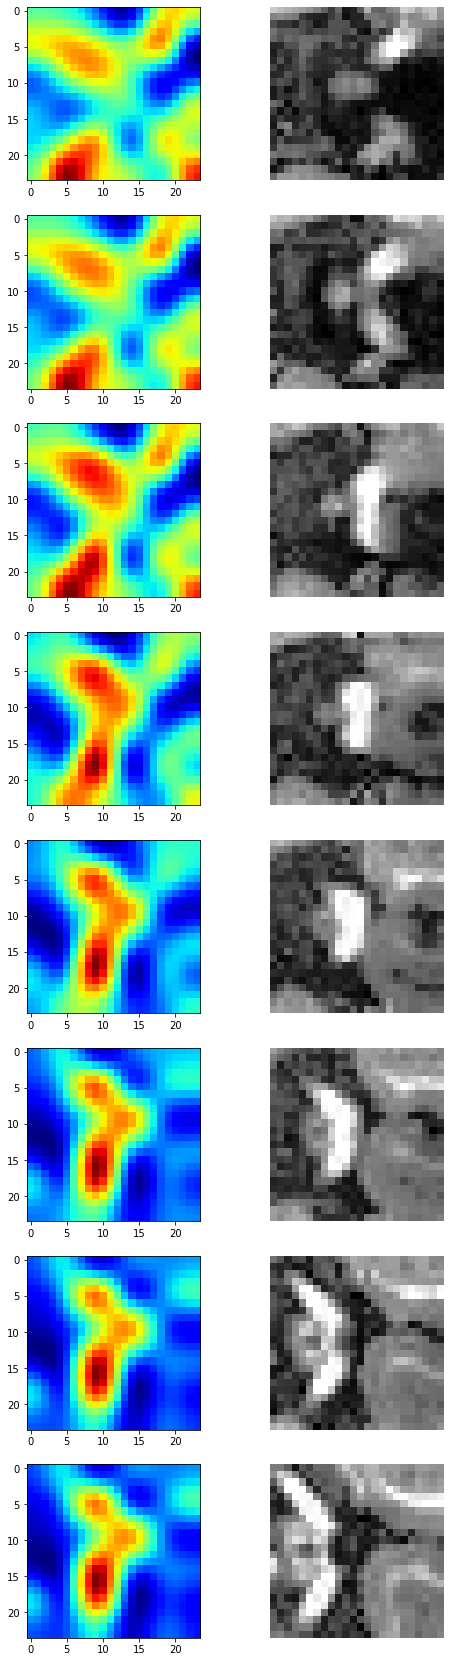

In [390]:
model=Classify_chiasm(8,2,0,256)
model.load_state_dict(torch.load('../../1_Data/3_Trained_classifier/8_2_0_256_1/optimal_weights'))

for batch in dataloaders_chiasm['dev_test']:
    print('ok!')
    
prediction = model(batch['chiasm']['data'])

print(accuracy_score(batch['label'],prediction.cpu().argmax(dim=1)))

image = 2
class_to_be_explained=0

example = example= batch['chiasm']['data'][image:(image+1)]

# For the first control
explanation = model.gradcam(example,class_to_be_explained) 

example_resampled = zoom(explanation, (4, 4, 4))

example_resampled.shape

fig = plt.figure(figsize=(8,30))

for i in range(example.shape[4]):
    
    plt.subplot(example.shape[4],2,2*i+1)
    plt.imshow(example_resampled[:,:,i], cmap='jet', alpha = 1)
    plt.subplot(example.shape[4],2,2*i+2)
    plt.imshow(example[0,0,:,:,i], cmap='gray', alpha = 1);
    #plt.title(str(labels.numpy()[i])+' vs prediction= '+str(output[i][0]))    
    plt.axis('off')

plt.show()

ok!
1.0
torch.Size([1, 32, 6, 6, 2])


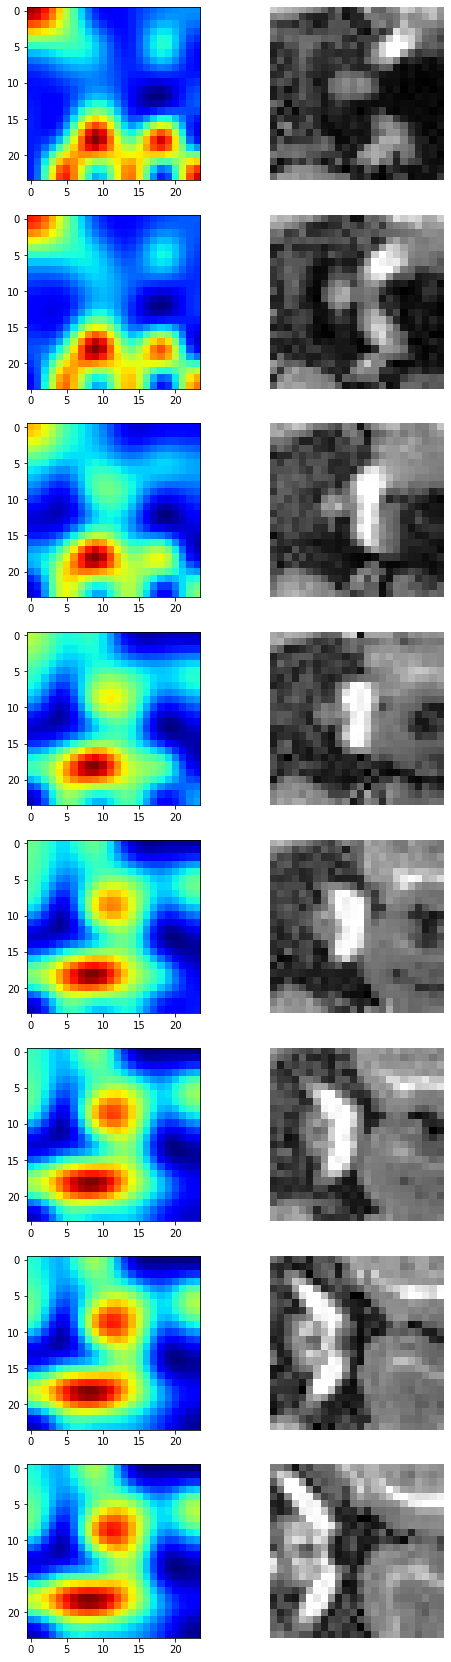

In [391]:
model=Classify_chiasm(8,2,0,256)
model.load_state_dict(torch.load('../../1_Data/3_Trained_classifier/8_2_0_256_2/optimal_weights'))

for batch in dataloaders_chiasm['dev_test']:
    print('ok!')
    
prediction = model(batch['chiasm']['data'])

print(accuracy_score(batch['label'],prediction.cpu().argmax(dim=1)))

image = 2
class_to_be_explained=0

example = example= batch['chiasm']['data'][image:(image+1)]

# For the first control
explanation = model.gradcam(example,class_to_be_explained) 

example_resampled = zoom(explanation, (4, 4, 4))

example_resampled.shape

fig = plt.figure(figsize=(8,30))

for i in range(example.shape[4]):
    
    plt.subplot(example.shape[4],2,2*i+1)
    plt.imshow(example_resampled[:,:,i], cmap='jet', alpha = 1)
    plt.subplot(example.shape[4],2,2*i+2)
    plt.imshow(example[0,0,:,:,i], cmap='gray', alpha = 1);
    #plt.title(str(labels.numpy()[i])+' vs prediction= '+str(output[i][0]))    
    plt.axis('off')

plt.show()

## LIME

In [89]:
model = Classify_chiasm(8,2,0,56)
model.load_state_dict(torch.load('../../1_Data/3_Trained_classifier/8_2_0_256_0.002/optimal_weights'))
model.requires_grad_(False);

In [90]:
for batch in dataloaders_chiasm['dev_test']:
    print('ok!')

ok!


In [91]:
batch['chiasm']['data'][:1,:].shape

torch.Size([1, 1, 24, 24, 8])

In [92]:
test=np.zeros([1,1,24,24,8,3])

for i in range(3):
    test[:,:,:,:,:,i]=batch['chiasm']['data'][:1,:].detach().numpy()

In [43]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(test[0,0,0,:,:,:], 
                                         model.to('cpu'), # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

TypeError: conv3d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: ([31;1mnumpy.ndarray[0m, [31;1mParameter[0m, [31;1mNoneType[0m, [31;1mtuple[0m, [31;1mtuple[0m, [31;1mtuple[0m, [32;1mint[0m)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: ([31;1mnumpy.ndarray[0m, [31;1mParameter[0m, [31;1mNoneType[0m, [31;1mtuple[0m, [31;1mtuple[0m, [31;1mtuple[0m, [32;1mint[0m)


## SHAP

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import keras.backend as K
import numpy as np
import json
import shap

# load pre-trained model and choose two images to explain
model = VGG16(weights='imagenet', include_top=True)
X,y = shap.datasets.imagenet50()
to_explain = X[[39,41]]

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(X, 7),
    local_smoothing=0 # std dev of smoothing noise
)
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)

In [ ]:
# ...include code from https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

import shap
import numpy as np

# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(x_test[1:5])

# plot the feature attributions
shap.image_plot(shap_values, -x_test[1:5])

## Calculate average input

## Calculate average latent representation of input

## Input that maximizes

In [71]:
def maximizing_input(folder_with_networks, num_steps = 1000):
    
    networks = [os.path.basename(x[0]) for x in os.walk(folder_with_networks)]
    networks=networks[1:] #[1:]
    
    for network in networks:
        
        # Create network and load the weights
        params=network.split('_')

        model = Classify_chiasm(int(params[0]),int(params[1]),int(params[2]),int(params[3]))
        model.load_state_dict(torch.load(folder_with_networks+network+'/optimal_weights'))
        model.requires_grad_(False);
        
        print(network)
        
        # Control
        x = torch.nn.Parameter(torch.rand(1,1,24,24,8, dtype=float), requires_grad=True) 
        x_saved = x.clone().detach()
        
        optim = torch.optim.Adam([x], lr=100)
        mse = torch.nn.MSELoss()
        y = torch.tensor(np.array([1,0,0]), dtype=float)
        
        for _ in range(num_steps):
            loss = mse(model(x.float()), y.float())
            loss.backward()
            optim.step()
            optim.zero_grad()
                
        # Thresholded difference
        fig = plt.figure(figsize=(20,6))

        threshold = 0# np.percentile(x.detach().numpy(),80)

        for i in range(x.detach().numpy().shape[4]):

            plt.subplot(2,x.detach().numpy().shape[4],i+1);
            plt.imshow(x.detach().numpy()[0,0,:,:,i]>threshold, cmap='gray')
            
            if i==0:
                plt.ylabel('Control thresholded')  
            
        #plt.pause(0.05)
        
        plt.show()
        
        # Albinism
        x = torch.nn.Parameter(torch.rand(1,1,24,24,8, dtype=float), requires_grad=True) 
        x_saved = x.clone().detach()
        
        optim = torch.optim.Adam([x], lr=100)
        mse = torch.nn.MSELoss()
        y = torch.tensor(np.array([0,1,0]), dtype=float)
        
        for _ in range(num_steps):
            loss = mse(model(x.float()), y.float())
            loss.backward()
            optim.step()
            optim.zero_grad()
                
        # Thresholded difference
        fig = plt.figure(figsize=(20,6))

        threshold = 0#np.percentile(x.detach().numpy(),80)

        for i in range(x.detach().numpy().shape[4]):

            plt.subplot(2,x.detach().numpy().shape[4],i+1);
            plt.imshow(x.detach().numpy()[0,0,:,:,i]>threshold, cmap='gray')
            
            if i==0:
                plt.ylabel('Albinism thresholded')  
            
        #plt.pause(0.05)
        
        plt.show()

8_2_0_256_0.0002


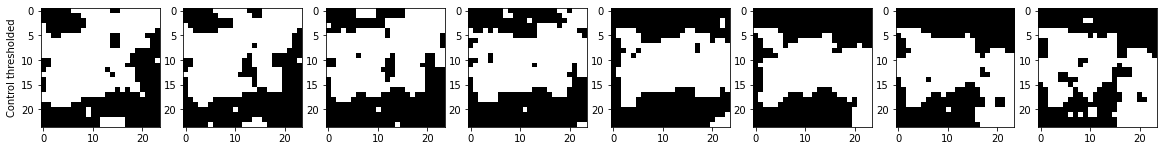

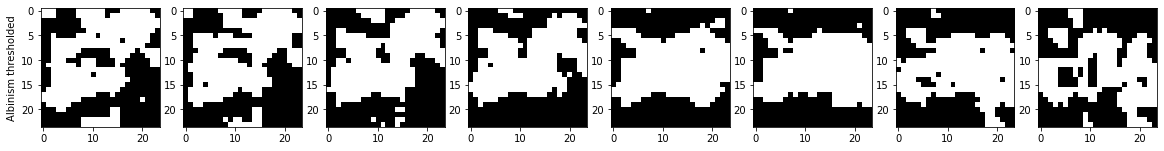

8_2_0_256_0.002


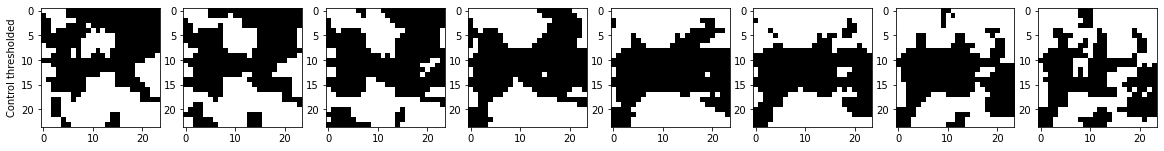

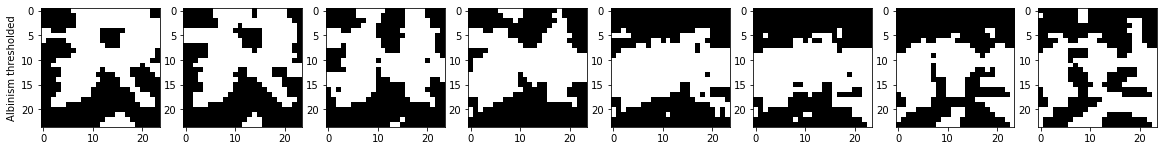

In [72]:
maximizing_input('../../1_Data/3_Trained_classifier/')

## SHAP

# Final testing